# Embedding People of Informatics

Here, embed individuals in different dimensions, as a form of dimensionality reduction. The following models were used to embed individuals:
1. tf-idf 
    - metadata
    - metadata + pdf
2. topic models 
    - topic model derived from metadata
    - topic model derived using documents in DBLP
    
    
## Methodology
1. Derive the models (for topic models, that is already derived in notebook on [topicModelling](topicModels/notebooks/topicModelling.ipynb).
2. Map individuals to the publications that they have published. (a bipartite graph between publications and individuals)
3. FOR each individual, using the publications for each individual, derive the embedding in the ***new*** space.
4. Calculate metrics such as **similarity** between individuals.

---

## Setup

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['seaborn-poster'])
%matplotlib inline

In [2]:
import networkx as nx
from helper_infnet import *
import artist_infnet as artist
from helper_embedding import *
# For dynamic reloading of modules
%load_ext autoreload
%autoreload 

2018-03-31 00:34:59,399 : INFO : 'pattern' package not found; tag filters are not available for English


In [3]:
# Load publication mapping:
# This mapping contains all the publicatitons that an individual have published.
# it does not filter out those that are only relevant to each time period
# The function:gen_toks in helper_embedding does that by concatenating publications that 
# are relevant to the time period under consideration in lookup_combined_toks 
# (which is filtered according to the year)
df_pubmapping = get_poinf_pub_mapping()

# Simple embedding using TF-IDF

1. Create TF-IDF for each terms
2. Using the mapping for `poinf-> publications` created, create list of tokens for each indivudal
3. As in information retrieval, find individuals who have are most similar. This is done using `cosine similarity`

## using metadata from 6yr

### Import metadata corpus:

In [8]:
corpus_metadata = lookup_combined_toks.toks_metada.tolist()

NameError: name 'lookup_combined_toks' is not defined

In [ ]:
# Create the TFIDF model using the dictionary based on the metadata from 1997-2017
dictionary_metada = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.meta'))

In [ ]:
len(dictionary_metada)

In [ ]:
tfidf_metada = TfidfModel(dictionary=dictionary_metada, normalize=True)
# tfidf_metada.save(os.path.join(DATA_DIR, 'models', 'tfidf', 'tfidf_metadata'))

In [ ]:
len(tfidf_metada.idfs.values())

In [ ]:
corpus_bows = [dictionary_metada.doc2bow(doc) for doc in corpus_metadata]

### Generate tfidf scores for each individual
Using the concatenation of publications (tokens) derived for each individual, we calculate the tfidf score for that individual.

This score is then used to calculate similarities.

In [ ]:
_indices = set(lookup_combined_toks.index)
def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]
    out = []
    for a in _df.toks_metada.tolist():
        out += a
    return out

In [ ]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [ ]:
df_pubmapping_4_collabgraph.head(3)

In [ ]:
df_pubmapping_4_collabgraph[
    'tfidf'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tfidf_metada[dictionary_metada.doc2bow(x)] if len(x) else None
    )

In [ ]:
df_pubmapping_4_collabgraph.info()

### Visualise the tfidf score for every individual:

This is required because of the high dimensionality of tfidf: 6222

In [ ]:
import sklearn.manifold as manifold

In [ ]:
tfidf_scores = df_pubmapping_4_collabgraph.tfidf.tolist()
tfidf_score_array = np.zeros([len(tfidf_scores), len(dictionary_metada)])
for i,score in enumerate(tfidf_scores):
    for (idx,v) in score:
        tfidf_score_array[i][idx] = v

In [ ]:
convert_sim2dist = np.vectorize(lambda sim: abs(1.0 - sim) if sim > 0 else 1.) # 

In [ ]:
fig = plt.figure(figsize=(40, 16))
perplexities = [2, 10, 20, 30, 50]
for i in range(5):
    # Use tsne for dimension reductiona
    manifold_tsne = manifold.TSNE(
        n_components=2, n_iter=2000, perplexity=perplexities[i])
    out = manifold_tsne.fit_transform(tfidf_score_array)
    x, y = np.hsplit(out, 2)

    ax = plt.subplot(2, 5, i + 1)
    ax.scatter(x, y)


    
for j in range(5):
    # Use tsne for dimension reductiona
    manifold_tsne = manifold.TSNE(
        n_components=2,
        n_iter=2000,
        perplexity=perplexities[i],
        metric='precomputed')
    out = manifold_tsne.fit_transform(convert_sim2dist(sim_matrix))
    x, y = np.hsplit(out, 2)

    ax = plt.subplot(2, 5, i + j + 2)
    ax.scatter(x, y)

### Similarity matrix

In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
_to_list([(1,2.3),(0,5)], 5)

In [ ]:
target_length = len(tfidf_metada.idfs.values())
num_individuals = len(df_pubmapping_4_collabgraph)
sim_matrix = np.zeros([num_individuals, num_individuals])

for i in range(num_individuals):
    a = _to_list(df_pubmapping_4_collabgraph.tfidf.iloc[i], target_length)
    for j in range(num_individuals):
        b = _to_list(df_pubmapping_4_collabgraph.tfidf.iloc[j], target_length)
        sim_matrix[i][j] = 1. - cosine(a, b)
    sim_matrix[i][i] = 0

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    sim_matrix,
    ax=ax,
    square=True,
    yticklabels="",
#     yticklabels=df_pubmapping_4_collabgraph.index,
    xticklabels="",
    cbar=False
)
fig.savefig('IMG/tfidf_embedding.png', format='png', transparent=True, bbox_inches='tight')

In [ ]:
np.max(sim_matrix)

In [ ]:
np.min(sim_matrix)

### Comparison with ground-truth collab-net:

In [ ]:
ground_truth_adj_mat = np.load(os.path.join(DATA_DIR, 'mat', 'infnet20yrs-adj-mat.pkl'))

In [ ]:
sns.heatmap(ground_truth_adj_mat)

In [ ]:
# Count number of edges:
np.sum(ground_truth_adj_mat)

In [ ]:
x_true = [0, 0, 1]
x = [0., .1, .2]
jaccard_dist(x_true, x, theta=.2)[0] == jaccard([0,0,1],[0,0,1])

In [ ]:
jaccard_dist(x_true, x, theta=.2)[1]

In [ ]:
thresholds, edges, distances = find_best_threshold(
    ground_truth_adj_mat, sim_matrix, num_iter=1000)

- epoch 66: threshold: 0.335 avg_dist: 0.638 num_edges: 1000
- epoch 67: threshold: 0.340 avg_dist: 0.644 num_edges: 938

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(thresholds, distances, 'b')
ax.set_xlabel('Thresholds')
ax.set_ylabel('Average Jaccard Distance')
ax.scatter(0.340, 0.644, marker='*', c='y')
ax2 = ax.twinx()
ax2.plot(thresholds, edges, 'r-')
ax2.set_ylabel('Total Number of Edges')
ax2.plot(
    np.linspace(0, 1., 100),
    np.repeat(940, 100),
    'c--',
    label='Actual number of edges')
fig.legend(
    [
        'Avg Jaccard Distance', 'Best epoch',
        'Number of Edges', 'Actual number of edges'
    ],
    loc=10, bbox_to_anchor=(0.6,0.7))

fig.savefig('IMG/tfidf_jacccard_plot.png', format='png', bbox_inches='tight', transparent=True)

In [ ]:
# Visualise the new heatmap!
threshold = thresholds[67]
sim_matrix_bin = np.ones(sim_matrix.shape)
sim_matrix_bin = np.where(sim_matrix<threshold,0,1)
np.fill_diagonal(sim_matrix_bin, 0)

In [ ]:
np.sum(sim_matrix_bin)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    sim_matrix_bin,
    ax=ax,
    square=True,
    yticklabels="",
#     yticklabels=df_pubmapping_4_collabgraph.index,
    xticklabels="",
    cbar=False
)
fig.savefig('IMG/tfidf_embedding_threshold.png', format='png', transparent=True, bbox_inches='tight')

In [ ]:
sim_matrix_bin.dump(os.path.join(DATA_DIR,'mat', 'tfidf_embedding_bin.pkl'))

---

# Topic models

## `topicnet-20yr`
Created using:
1. infnet-20yr
2. tm-20yr

### Deriving `topicnet-20yr`#

In [4]:
# filter our lookup table according to the tokens
lookup_combined_toks = prepare_toks(top=1997,bottom=2017)

In [5]:
# Load Collaboration Network
collabnet = pd.read_csv('../../data/data_schoolofinf/poinf_collabgraph_1997-2017.txt', 
                       sep='\n',
                       names=['id'])
adj_mat = np.load('../../data/data_schoolofinf/mat/infnet20yrs-adj-mat.pkl')

In [10]:
# Gather the publications for each individual:
topicnet = collabnet.join(df_pubmapping.set_index('id'), how='left', on='id')

In [11]:
# Load Topic Model
tm = models.LdaModel.load('../../topicModel/src/tmfull_meta/res/best_ldamodel')
print(tm.minimum_probability)
dict_tm = Dictionary.load('../../data/data_schoolofinf/corpora/dictionary.meta')

# Generate tokens for each publication:
topicnet['toks'] = topicnet['pub_ids'].apply(lambda a: gen_toks(a, lookup_combined_toks))

# use TM for infernece on the model
topicnet['topic_probs'] = topicnet['toks'].apply(lambda a: tm.get_document_topics(dict_tm.doc2bow(a))
                                                if len(a) else None)

2018-03-31 00:28:09,437 : INFO : loading LdaModel object from ../../topicModel/src/tmfull_meta/res/best_ldamodel
2018-03-31 00:28:09,519 : INFO : loading expElogbeta from ../../topicModel/src/tmfull_meta/res/best_ldamodel.expElogbeta.npy with mmap=None
2018-03-31 00:28:09,540 : INFO : setting ignored attribute dispatcher to None
2018-03-31 00:28:09,541 : INFO : setting ignored attribute state to None
2018-03-31 00:28:09,542 : INFO : setting ignored attribute id2word to None
2018-03-31 00:28:09,542 : INFO : loaded ../../topicModel/src/tmfull_meta/res/best_ldamodel
2018-03-31 00:28:09,543 : INFO : loading LdaModel object from ../../topicModel/src/tmfull_meta/res/best_ldamodel.state
2018-03-31 00:28:09,576 : INFO : loaded ../../topicModel/src/tmfull_meta/res/best_ldamodel.state
2018-03-31 00:28:09,579 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.meta
2018-03-31 00:28:09,609 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.meta


0.01


In [12]:
# Generate cosine similarity between individuals:
cosim = compare_researchers(topicnet.topic_probs.tolist(), tm.num_topics)

In [13]:
# find the best threshold:
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001)

2018-03-31 00:28:19,288 : INFO : Number of ground_truth_edges: 470.0
2018-03-31 00:28:19,288 : INFO : binary edges: True
2018-03-31 00:28:19,296 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.974 num_edges: 18324
2018-03-31 00:28:19,304 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.974 num_edges: 18189
2018-03-31 00:28:19,312 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.974 num_edges: 18051
2018-03-31 00:28:19,320 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.974 num_edges: 17914
2018-03-31 00:28:19,328 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.974 num_edges: 17771
2018-03-31 00:28:19,335 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.973 num_edges: 17652
2018-03-31 00:28:19,342 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.973 num_edges: 17514
2018-03-31 00:28:19,349 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.973 num_edges: 17366
2018-03-31 00:28:19,358 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.973 num_edges: 17229
2018-03-31 00:28:19,365 : INFO : epoch 9: threshold

2018-03-31 00:28:19,960 : INFO : epoch 87: threshold: 0.088 avg_dist: 0.948 num_edges: 9692
2018-03-31 00:28:19,968 : INFO : epoch 88: threshold: 0.089 avg_dist: 0.947 num_edges: 9632
2018-03-31 00:28:19,975 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.947 num_edges: 9564
2018-03-31 00:28:19,983 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.947 num_edges: 9513
2018-03-31 00:28:19,990 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.946 num_edges: 9463
2018-03-31 00:28:19,998 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.946 num_edges: 9402
2018-03-31 00:28:20,006 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.946 num_edges: 9336
2018-03-31 00:28:20,014 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.945 num_edges: 9282
2018-03-31 00:28:20,023 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.945 num_edges: 9231
2018-03-31 00:28:20,030 : INFO : epoch 96: threshold: 0.097 avg_dist: 0.945 num_edges: 9168
2018-03-31 00:28:20,038 : INFO : epoch 97: threshold: 0.098 avg_dist: 0.944 num_

2018-03-31 00:28:20,643 : INFO : epoch 176: threshold: 0.177 avg_dist: 0.922 num_edges: 6088
2018-03-31 00:28:20,651 : INFO : epoch 177: threshold: 0.178 avg_dist: 0.921 num_edges: 6051
2018-03-31 00:28:20,659 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.921 num_edges: 6022
2018-03-31 00:28:20,667 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.921 num_edges: 5996
2018-03-31 00:28:20,674 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.920 num_edges: 5984
2018-03-31 00:28:20,681 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.920 num_edges: 5967
2018-03-31 00:28:20,689 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.920 num_edges: 5944
2018-03-31 00:28:20,697 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.920 num_edges: 5920
2018-03-31 00:28:20,704 : INFO : epoch 184: threshold: 0.185 avg_dist: 0.919 num_edges: 5894
2018-03-31 00:28:20,711 : INFO : epoch 185: threshold: 0.186 avg_dist: 0.919 num_edges: 5863
2018-03-31 00:28:20,719 : INFO : epoch 186: threshold: 0.187 avg_dist:

2018-03-31 00:28:21,326 : INFO : epoch 265: threshold: 0.266 avg_dist: 0.896 num_edges: 4322
2018-03-31 00:28:21,333 : INFO : epoch 266: threshold: 0.267 avg_dist: 0.896 num_edges: 4300
2018-03-31 00:28:21,341 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.896 num_edges: 4283
2018-03-31 00:28:21,348 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.896 num_edges: 4270
2018-03-31 00:28:21,356 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.895 num_edges: 4256
2018-03-31 00:28:21,364 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.895 num_edges: 4240
2018-03-31 00:28:21,373 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.895 num_edges: 4224
2018-03-31 00:28:21,380 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.895 num_edges: 4208
2018-03-31 00:28:21,388 : INFO : epoch 273: threshold: 0.274 avg_dist: 0.895 num_edges: 4194
2018-03-31 00:28:21,395 : INFO : epoch 274: threshold: 0.275 avg_dist: 0.894 num_edges: 4177
2018-03-31 00:28:21,403 : INFO : epoch 275: threshold: 0.276 avg_dist:

2018-03-31 00:28:22,010 : INFO : epoch 354: threshold: 0.355 avg_dist: 0.871 num_edges: 3162
2018-03-31 00:28:22,017 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.870 num_edges: 3146
2018-03-31 00:28:22,024 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.870 num_edges: 3136
2018-03-31 00:28:22,032 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.870 num_edges: 3128
2018-03-31 00:28:22,039 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.870 num_edges: 3117
2018-03-31 00:28:22,046 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.870 num_edges: 3111
2018-03-31 00:28:22,054 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.870 num_edges: 3099
2018-03-31 00:28:22,061 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.870 num_edges: 3093
2018-03-31 00:28:22,069 : INFO : epoch 362: threshold: 0.363 avg_dist: 0.869 num_edges: 3082
2018-03-31 00:28:22,077 : INFO : epoch 363: threshold: 0.364 avg_dist: 0.869 num_edges: 3074
2018-03-31 00:28:22,084 : INFO : epoch 364: threshold: 0.365 avg_dist:

2018-03-31 00:28:22,745 : INFO : epoch 443: threshold: 0.444 avg_dist: 0.850 num_edges: 2390
2018-03-31 00:28:22,753 : INFO : epoch 444: threshold: 0.445 avg_dist: 0.849 num_edges: 2381
2018-03-31 00:28:22,760 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.848 num_edges: 2369
2018-03-31 00:28:22,768 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.848 num_edges: 2362
2018-03-31 00:28:22,776 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.849 num_edges: 2357
2018-03-31 00:28:22,784 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.848 num_edges: 2352
2018-03-31 00:28:22,791 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.848 num_edges: 2348
2018-03-31 00:28:22,798 : INFO : epoch 450: threshold: 0.451 avg_dist: 0.848 num_edges: 2341
2018-03-31 00:28:22,806 : INFO : epoch 451: threshold: 0.452 avg_dist: 0.848 num_edges: 2336
2018-03-31 00:28:22,814 : INFO : epoch 452: threshold: 0.453 avg_dist: 0.848 num_edges: 2330
2018-03-31 00:28:22,821 : INFO : epoch 453: threshold: 0.454 avg_dist:

2018-03-31 00:28:23,415 : INFO : epoch 531: threshold: 0.532 avg_dist: 0.829 num_edges: 1793
2018-03-31 00:28:23,422 : INFO : epoch 532: threshold: 0.533 avg_dist: 0.829 num_edges: 1788
2018-03-31 00:28:23,430 : INFO : epoch 533: threshold: 0.534 avg_dist: 0.829 num_edges: 1780
2018-03-31 00:28:23,437 : INFO : epoch 534: threshold: 0.535 avg_dist: 0.829 num_edges: 1777
2018-03-31 00:28:23,445 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.829 num_edges: 1768
2018-03-31 00:28:23,453 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.829 num_edges: 1765
2018-03-31 00:28:23,462 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.829 num_edges: 1764
2018-03-31 00:28:23,471 : INFO : epoch 538: threshold: 0.539 avg_dist: 0.829 num_edges: 1759
2018-03-31 00:28:23,481 : INFO : epoch 539: threshold: 0.540 avg_dist: 0.828 num_edges: 1750
2018-03-31 00:28:23,492 : INFO : epoch 540: threshold: 0.541 avg_dist: 0.828 num_edges: 1746
2018-03-31 00:28:23,500 : INFO : epoch 541: threshold: 0.542 avg_dist:

2018-03-31 00:28:24,104 : INFO : epoch 619: threshold: 0.620 avg_dist: 0.814 num_edges: 1336
2018-03-31 00:28:24,112 : INFO : epoch 620: threshold: 0.621 avg_dist: 0.813 num_edges: 1333
2018-03-31 00:28:24,119 : INFO : epoch 621: threshold: 0.622 avg_dist: 0.812 num_edges: 1329
2018-03-31 00:28:24,127 : INFO : epoch 622: threshold: 0.623 avg_dist: 0.812 num_edges: 1325
2018-03-31 00:28:24,186 : INFO : epoch 623: threshold: 0.624 avg_dist: 0.812 num_edges: 1320
2018-03-31 00:28:24,194 : INFO : epoch 624: threshold: 0.625 avg_dist: 0.812 num_edges: 1312
2018-03-31 00:28:24,203 : INFO : epoch 625: threshold: 0.626 avg_dist: 0.811 num_edges: 1306
2018-03-31 00:28:24,210 : INFO : epoch 626: threshold: 0.627 avg_dist: 0.811 num_edges: 1302
2018-03-31 00:28:24,217 : INFO : epoch 627: threshold: 0.628 avg_dist: 0.810 num_edges: 1299
2018-03-31 00:28:24,224 : INFO : epoch 628: threshold: 0.629 avg_dist: 0.810 num_edges: 1293
2018-03-31 00:28:24,231 : INFO : epoch 629: threshold: 0.630 avg_dist:

2018-03-31 00:28:24,829 : INFO : epoch 708: threshold: 0.709 avg_dist: 0.791 num_edges: 936
2018-03-31 00:28:24,838 : INFO : epoch 709: threshold: 0.710 avg_dist: 0.792 num_edges: 929
2018-03-31 00:28:24,845 : INFO : epoch 710: threshold: 0.711 avg_dist: 0.791 num_edges: 924
2018-03-31 00:28:24,852 : INFO : epoch 711: threshold: 0.712 avg_dist: 0.791 num_edges: 923
2018-03-31 00:28:24,861 : INFO : epoch 712: threshold: 0.713 avg_dist: 0.790 num_edges: 921
2018-03-31 00:28:24,868 : INFO : epoch 713: threshold: 0.714 avg_dist: 0.790 num_edges: 916
2018-03-31 00:28:24,875 : INFO : epoch 714: threshold: 0.715 avg_dist: 0.792 num_edges: 911
2018-03-31 00:28:24,882 : INFO : epoch 715: threshold: 0.716 avg_dist: 0.791 num_edges: 908
2018-03-31 00:28:24,890 : INFO : epoch 716: threshold: 0.717 avg_dist: 0.791 num_edges: 903
2018-03-31 00:28:24,897 : INFO : epoch 717: threshold: 0.718 avg_dist: 0.791 num_edges: 899
2018-03-31 00:28:24,905 : INFO : epoch 718: threshold: 0.719 avg_dist: 0.791 num

2018-03-31 00:28:25,496 : INFO : epoch 798: threshold: 0.799 avg_dist: 0.804 num_edges: 571
2018-03-31 00:28:25,503 : INFO : epoch 799: threshold: 0.800 avg_dist: 0.804 num_edges: 567
2018-03-31 00:28:25,510 : INFO : epoch 800: threshold: 0.801 avg_dist: 0.804 num_edges: 565
2018-03-31 00:28:25,517 : INFO : epoch 801: threshold: 0.802 avg_dist: 0.805 num_edges: 561
2018-03-31 00:28:25,525 : INFO : epoch 802: threshold: 0.803 avg_dist: 0.804 num_edges: 559
2018-03-31 00:28:25,533 : INFO : epoch 803: threshold: 0.804 avg_dist: 0.804 num_edges: 557
2018-03-31 00:28:25,540 : INFO : epoch 804: threshold: 0.805 avg_dist: 0.804 num_edges: 552
2018-03-31 00:28:25,547 : INFO : epoch 805: threshold: 0.806 avg_dist: 0.805 num_edges: 549
2018-03-31 00:28:25,554 : INFO : epoch 806: threshold: 0.807 avg_dist: 0.804 num_edges: 545
2018-03-31 00:28:25,562 : INFO : epoch 807: threshold: 0.808 avg_dist: 0.804 num_edges: 545
2018-03-31 00:28:25,570 : INFO : epoch 808: threshold: 0.809 avg_dist: 0.806 num

2018-03-31 00:28:26,204 : INFO : epoch 887: threshold: 0.888 avg_dist: 0.829 num_edges: 312
2018-03-31 00:28:26,213 : INFO : epoch 888: threshold: 0.889 avg_dist: 0.828 num_edges: 308
2018-03-31 00:28:26,220 : INFO : epoch 889: threshold: 0.890 avg_dist: 0.827 num_edges: 307
2018-03-31 00:28:26,226 : INFO : epoch 890: threshold: 0.891 avg_dist: 0.826 num_edges: 303
2018-03-31 00:28:26,234 : INFO : epoch 891: threshold: 0.892 avg_dist: 0.825 num_edges: 301
2018-03-31 00:28:26,241 : INFO : epoch 892: threshold: 0.893 avg_dist: 0.824 num_edges: 299
2018-03-31 00:28:26,249 : INFO : epoch 893: threshold: 0.894 avg_dist: 0.825 num_edges: 297
2018-03-31 00:28:26,256 : INFO : epoch 894: threshold: 0.895 avg_dist: 0.829 num_edges: 292
2018-03-31 00:28:26,263 : INFO : epoch 895: threshold: 0.896 avg_dist: 0.830 num_edges: 286
2018-03-31 00:28:26,270 : INFO : epoch 896: threshold: 0.897 avg_dist: 0.829 num_edges: 284
2018-03-31 00:28:26,277 : INFO : epoch 897: threshold: 0.898 avg_dist: 0.828 num

2018-03-31 00:28:26,859 : INFO : epoch 976: threshold: 0.977 avg_dist: 0.942 num_edges: 41
2018-03-31 00:28:26,867 : INFO : epoch 977: threshold: 0.978 avg_dist: 0.947 num_edges: 38
2018-03-31 00:28:26,874 : INFO : epoch 978: threshold: 0.979 avg_dist: 0.947 num_edges: 35
2018-03-31 00:28:26,881 : INFO : epoch 979: threshold: 0.980 avg_dist: 0.951 num_edges: 32
2018-03-31 00:28:26,888 : INFO : epoch 980: threshold: 0.981 avg_dist: 0.953 num_edges: 31
2018-03-31 00:28:26,895 : INFO : epoch 981: threshold: 0.982 avg_dist: 0.956 num_edges: 30
2018-03-31 00:28:26,902 : INFO : epoch 982: threshold: 0.983 avg_dist: 0.959 num_edges: 28
2018-03-31 00:28:26,910 : INFO : epoch 983: threshold: 0.984 avg_dist: 0.960 num_edges: 26
2018-03-31 00:28:26,917 : INFO : epoch 984: threshold: 0.985 avg_dist: 0.961 num_edges: 25
2018-03-31 00:28:26,925 : INFO : epoch 985: threshold: 0.986 avg_dist: 0.960 num_edges: 24
2018-03-31 00:28:26,933 : INFO : epoch 986: threshold: 0.987 avg_dist: 0.960 num_edges: 23

threshold: 0.836 dist 0.783092 (735, 0.736) edges 472/470.0 (835)


threshold: 0.836 dist 0.783092 (735, 0.736) edges 472/470.0 (835)

In [14]:
# Set the edges:
topicnet_adj_mat = set_edges(cosim, best_threshold, binary=True)

2018-03-31 00:28:29,168 : INFO : dimension: 194, 194


In [11]:
# Save the topicnet adj-mat
topicnet_adj_mat.dump(open('./res/topicnet20yr_adjmat.pkl','wb'))

### Visualise

#### Thresholding:

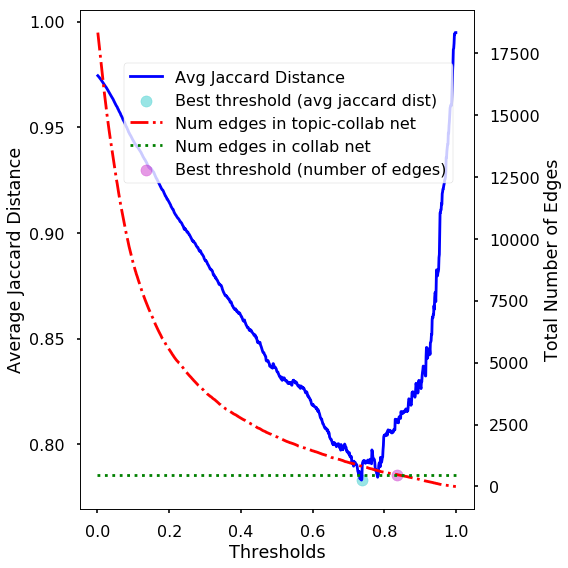

In [15]:
f = threshold_plot(
    thresholds,
    distances,
    edges,
    best_threshold,
    closest_edges,
    best_j_dist_threshold,
    lowest_avg_distances,
    adj_mat
)

In [13]:
f.savefig(
    './IMG/topicnet20yr_thresholding.png', format='png', bbox_inches='tight')

####  As series of matrices:

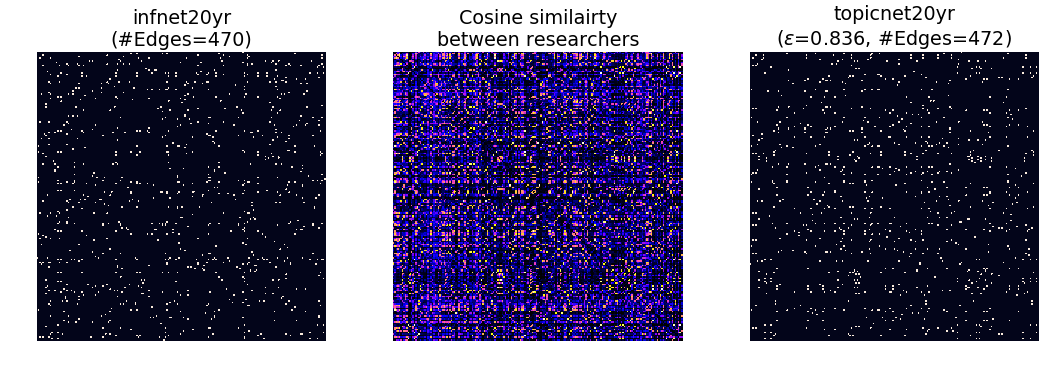

In [16]:
f = plt.figure(figsize=(15, 5))
# ORIGINAL COLALB NET
ax1 = f.add_subplot(131)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
ax1.set_title('infnet20yr\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
ax2 = f.add_subplot(132)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
ax3 = f.add_subplot(133)
ax3.axis('off')
sns.heatmap(topicnet_adj_mat, cbar=False, square=True, ax=ax3)
ax3.set_title('topicnet20yr\n($\epsilon$={:.3f}, #Edges={})'.format(
    best_threshold,
    int(np.sum(topicnet_adj_mat) // 2)))

f.tight_layout()

In [15]:
f.savefig('./IMG/topicnet20yr_adjmats.png')

#### As networks:

In [16]:
g_topicnet20yr = adj_mat_to_graph(topicnet_adj_mat, collabnet.id.tolist())

In [17]:
print(nx.info(g_topicnet20yr))

Name: 
Type: Graph
Number of nodes: 168
Number of edges: 472
Average degree:   5.6190


2018-03-30 23:29:27,911 : INFO : SAVE_GRAPHS: True


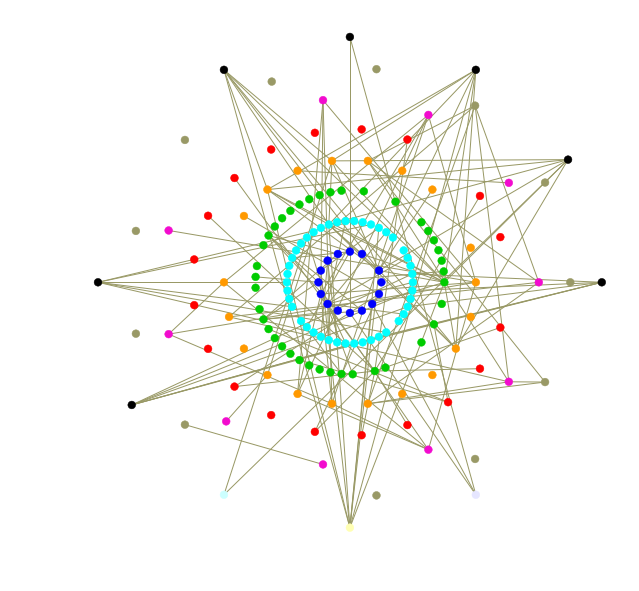

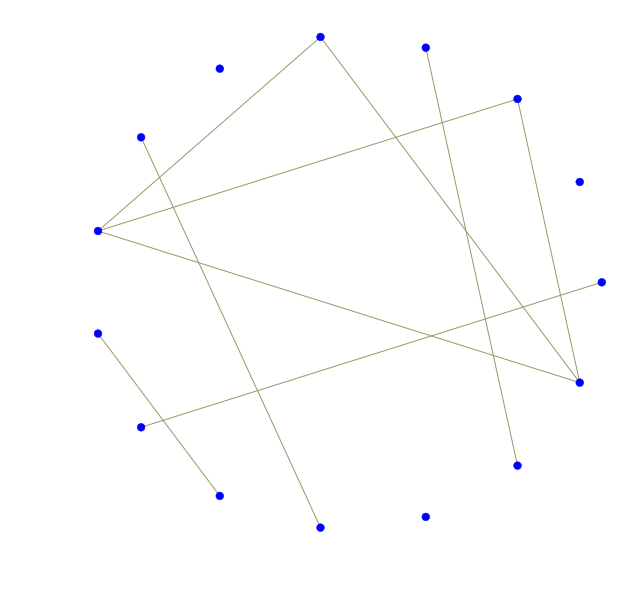

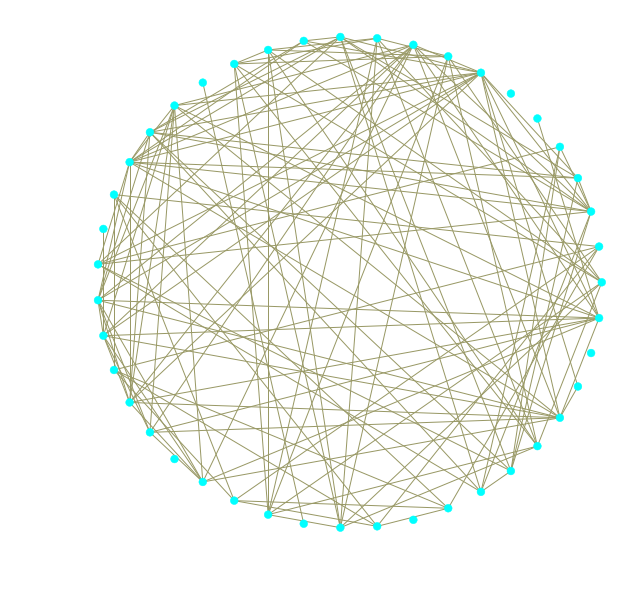

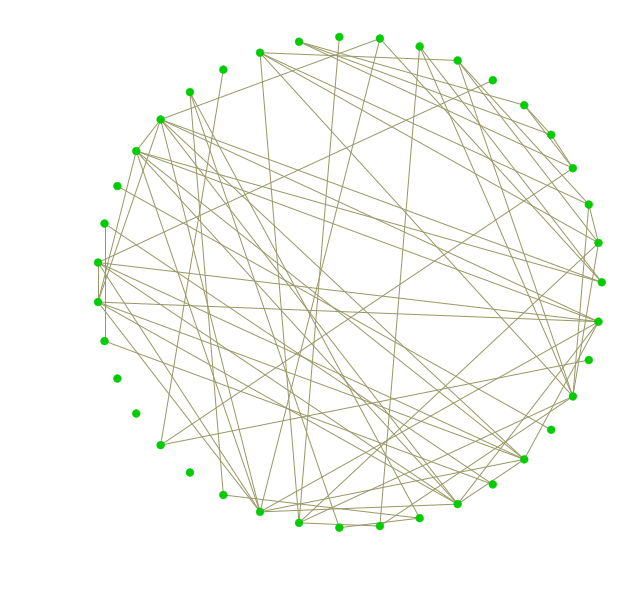

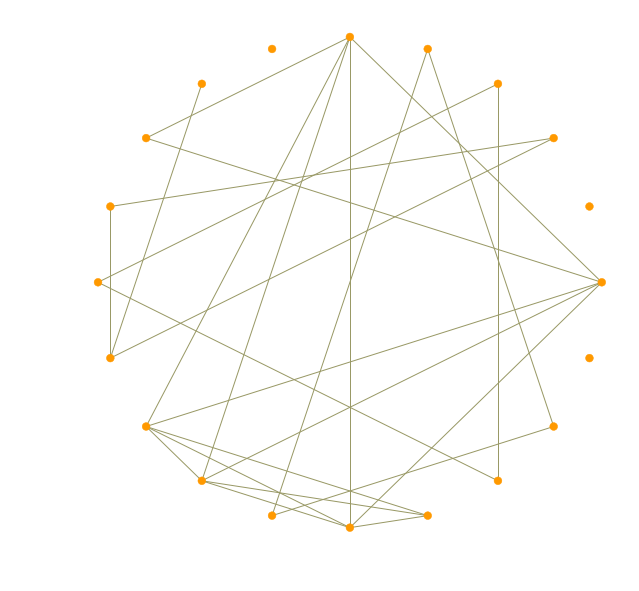

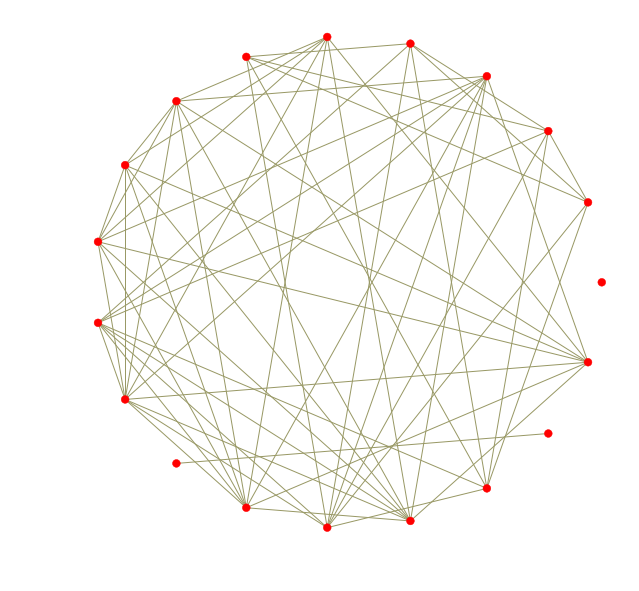

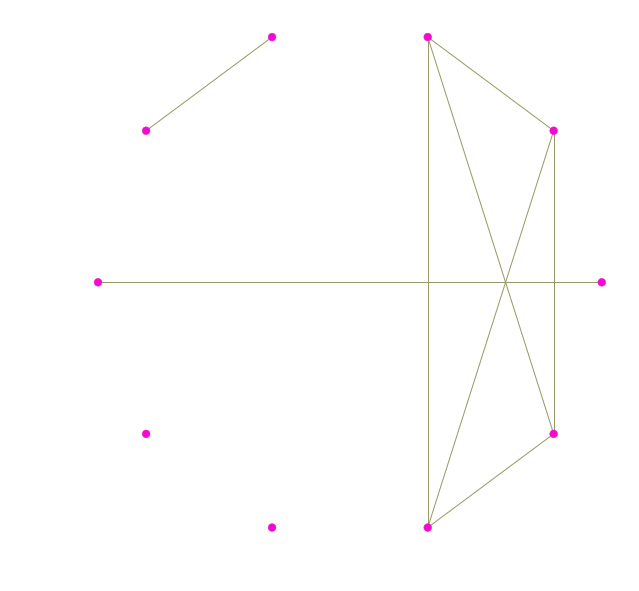

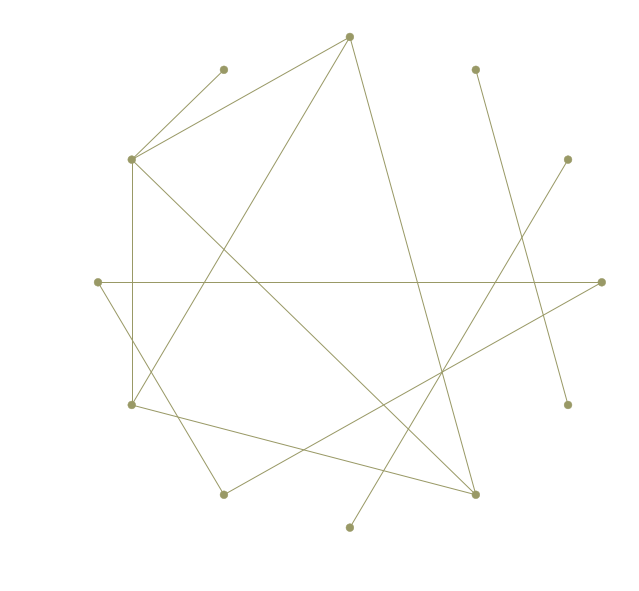

In [18]:
artist.draw_default_layout(
    g_topicnet20yr,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='topicnet20yr',
    SAVE_GRAPHS=True)

2018-03-30 23:29:45,000 : INFO : SAVE_GRAPHS: True


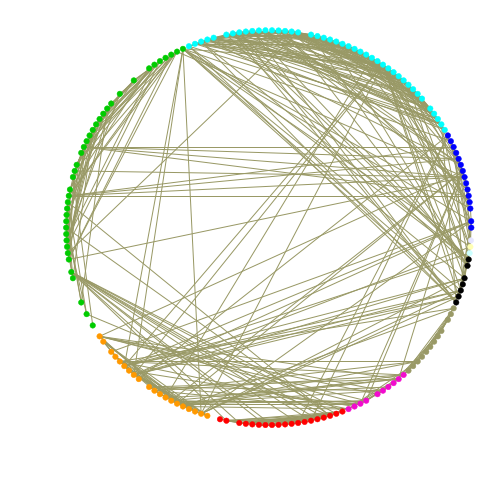

In [20]:
artist.draw_circular_layout(
    g_topicnet20yr,
    get_lookup_poinf(),
    file_prefix='topicnet20yr',
    SAVE_GRAPHS=True)

#### Dim reduction of individuals

In [25]:
## Visualise where each author is in topic space; use mds as dimensionality reduction
def display_tm_embedding(list_of_probs, n_topics, use_xs=None):
    """
    Takes in the list of probabilities inferred by topic model
    generate the embedding in 2D space
    
    """
    if use_xs is None:
        # Only generate feature space if required; reduce overhead when trying different plot
        # Create dimensionality features
        feature_space = convert_feature_space(list_of_probs, n_topics)
        # dimensionality reeduction:
        mds = MDS(n_components=2, verbose=1)
        xs = mds.fit_transform(feature_space)
    
#     # Scatter plot:
#     ## Generate colors:
#     color_palette  = sns.color_palette('cubehelix',n_colors=n_topics)
#     ## Use the argmax of each topic to determine the color
#     sample_topics = np.argmax(feature_space,axis=1)
#     cluster_colors = [color_palette[x] for x in sample_topics]
#     f = plt.figure(figsize=(8,8))
#     ax1 = f.add_subplot(111)
#     ls = []
#     for i in range(n_topics):
#         # plot each topic 
#         _idx = sample_topics == i
#         _xs = xs[_idx]
#         _ls = ax1.scatter(**_xs, c=cluster_colors[_idx], alpha=0.4)
#         ls.append(_ls)
#     _leg = ['Topic {}'.format(i) for i in range(n_topics)]
#     ax1.legend(ls,_leg, scatterpoints=1)
    return xs#, f # x1,x2

def convert_feature_space(list_of_probs, n_topics):
    feature_space = np.zeros([len(list_of_probs), n_topics],dtype=np.float32)
    for i,tup_prob in enumerate(list_of_probs):
        for (topic, prob) in tup_prob:
            feature_space[i][topic] = prob
    return feature_space

In [26]:
list_of_probs = topicnet20yr.tm20yr_probs.tolist()
n_topics = tmfull_meta.num_topics
xs = display_tm_embedding(list_of_probs, n_topics)

NameError: name 'topicnet20yr' is not defined

In [ ]:
# Scatter plot:
## Generate colors:
from math import ceil

color_palette1 = sns.color_palette('tab20', n_colors=ceil(n_topics/2))
color_palette2 = sns.color_palette('tab20', n_colors=ceil(n_topics/2))
## Use the argmax of each topic to determine the color
sample_topics = np.argmax(feature_space, axis=1)
# cluster_colors = [color_palette1[x] for x in sample_topics if x%2==0 else color_palette2[x]]
cluster_colors = []
for x in sample_topics:
    if x <= n_topics//2:
        cluster_colors.append(color_palette1[x])
    else:
        x = x - n_topics//2
        cluster_colors.append(color_palette2[x])
cluster_colors = np.array(cluster_colors)
f = plt.figure(figsize=(10, 10))
ax1 = f.add_subplot(111)
ls = []
for i in range(n_topics):
    # plot each topic
    _idx = sample_topics == i
    _xs = xs[_idx]
    _ls = ax1.scatter(_xs[:,0],_xs[:,1], c=cluster_colors[_idx], alpha=0.4, marker='${}$'.format(i))
    ls.append(_ls)
# _leg = ['Topic {}'.format(i) for i in range(n_topics)]
# plt.legend(ls, _leg, scatterpoints=1, loc=0, ncol=5)
ax1.axis('off')

## `topicnetref-20yr`

### Deriving `topicnetref-20yr`

In [21]:
# Since we are using the same base, we do not need to reload it again!
# Loading the new topic model:
tm = models.LdaModel.load('../../topicModel/src/tmdblp/tm_dblp')
dict_tm = Dictionary.load(
    '../../data/data_dblp/corpora/dictionary.dblp.1997-2017')

2018-03-30 23:29:53,454 : INFO : loading LdaModel object from ../../topicModel/src/tmdblp/tm_dblp
2018-03-30 23:29:53,552 : INFO : loading expElogbeta from ../../topicModel/src/tmdblp/tm_dblp.expElogbeta.npy with mmap=None
2018-03-30 23:29:53,612 : INFO : setting ignored attribute id2word to None
2018-03-30 23:29:53,612 : INFO : setting ignored attribute dispatcher to None
2018-03-30 23:29:53,613 : INFO : setting ignored attribute state to None
2018-03-30 23:29:53,613 : INFO : loaded ../../topicModel/src/tmdblp/tm_dblp
2018-03-30 23:29:53,614 : INFO : loading LdaModel object from ../../topicModel/src/tmdblp/tm_dblp.state
2018-03-30 23:29:54,045 : INFO : loaded ../../topicModel/src/tmdblp/tm_dblp.state
2018-03-30 23:29:54,108 : INFO : loading Dictionary object from ../../data/data_dblp/corpora/dictionary.dblp.1997-2017
2018-03-30 23:29:54,158 : INFO : loaded ../../data/data_dblp/corpora/dictionary.dblp.1997-2017


In [22]:
# Generate topic probabilities for each publication using the dictionary for DBLP
tm.minimum_probability = 0.001
topicnet['topic_probs'] = topicnet.toks.apply(
    lambda a: tm.get_document_topics(dict_tm.doc2bow(a)) if len(a) else None)

In [23]:
# Generate cosine similarity
cosim = compare_researchers(topicnet.topic_probs.tolist(), tm.num_topics)

In [24]:
# find best threshold
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001)

2018-03-30 23:30:06,954 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.975 num_edges: 18710
2018-03-30 23:30:06,962 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.975 num_edges: 18704
2018-03-30 23:30:06,969 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.975 num_edges: 18694
2018-03-30 23:30:06,975 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.975 num_edges: 18675
2018-03-30 23:30:06,982 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.975 num_edges: 18652
2018-03-30 23:30:06,989 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.975 num_edges: 18625
2018-03-30 23:30:06,996 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.975 num_edges: 18596
2018-03-30 23:30:07,003 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.975 num_edges: 18562
2018-03-30 23:30:07,010 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.975 num_edges: 18528
2018-03-30 23:30:07,017 : INFO : epoch 9: threshold: 0.010 avg_dist: 0.975 num_edges: 18499
2018-03-30 23:30:07,024 : INFO : epoch 10: threshold: 0.011 avg_dist: 0.975 num_

2018-03-30 23:30:07,589 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.961 num_edges: 12464
2018-03-30 23:30:07,597 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.961 num_edges: 12384
2018-03-30 23:30:07,604 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.961 num_edges: 12309
2018-03-30 23:30:07,612 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.960 num_edges: 12219
2018-03-30 23:30:07,619 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.960 num_edges: 12159
2018-03-30 23:30:07,626 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.960 num_edges: 12085
2018-03-30 23:30:07,633 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.959 num_edges: 12004
2018-03-30 23:30:07,641 : INFO : epoch 96: threshold: 0.097 avg_dist: 0.959 num_edges: 11929
2018-03-30 23:30:07,649 : INFO : epoch 97: threshold: 0.098 avg_dist: 0.959 num_edges: 11858
2018-03-30 23:30:07,656 : INFO : epoch 98: threshold: 0.099 avg_dist: 0.959 num_edges: 11802
2018-03-30 23:30:07,664 : INFO : epoch 99: threshold: 0.100 avg_dist: 

2018-03-30 23:30:08,245 : INFO : epoch 177: threshold: 0.178 avg_dist: 0.935 num_edges: 7744
2018-03-30 23:30:08,252 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.935 num_edges: 7715
2018-03-30 23:30:08,259 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.935 num_edges: 7683
2018-03-30 23:30:08,268 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.935 num_edges: 7647
2018-03-30 23:30:08,275 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.934 num_edges: 7612
2018-03-30 23:30:08,283 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.934 num_edges: 7576
2018-03-30 23:30:08,290 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.934 num_edges: 7532
2018-03-30 23:30:08,297 : INFO : epoch 184: threshold: 0.185 avg_dist: 0.933 num_edges: 7499
2018-03-30 23:30:08,304 : INFO : epoch 185: threshold: 0.186 avg_dist: 0.933 num_edges: 7472
2018-03-30 23:30:08,311 : INFO : epoch 186: threshold: 0.187 avg_dist: 0.933 num_edges: 7443
2018-03-30 23:30:08,319 : INFO : epoch 187: threshold: 0.188 avg_dist:

2018-03-30 23:30:08,900 : INFO : epoch 265: threshold: 0.266 avg_dist: 0.910 num_edges: 5264
2018-03-30 23:30:08,909 : INFO : epoch 266: threshold: 0.267 avg_dist: 0.909 num_edges: 5240
2018-03-30 23:30:08,918 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.909 num_edges: 5226
2018-03-30 23:30:08,926 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.908 num_edges: 5210
2018-03-30 23:30:08,935 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.908 num_edges: 5191
2018-03-30 23:30:08,943 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.908 num_edges: 5175
2018-03-30 23:30:08,951 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.907 num_edges: 5163
2018-03-30 23:30:08,960 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.907 num_edges: 5141
2018-03-30 23:30:08,969 : INFO : epoch 273: threshold: 0.274 avg_dist: 0.906 num_edges: 5116
2018-03-30 23:30:08,978 : INFO : epoch 274: threshold: 0.275 avg_dist: 0.906 num_edges: 5100
2018-03-30 23:30:08,985 : INFO : epoch 275: threshold: 0.276 avg_dist:

2018-03-30 23:30:09,567 : INFO : epoch 354: threshold: 0.355 avg_dist: 0.880 num_edges: 3762
2018-03-30 23:30:09,575 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.880 num_edges: 3745
2018-03-30 23:30:09,583 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.880 num_edges: 3734
2018-03-30 23:30:09,590 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.879 num_edges: 3713
2018-03-30 23:30:09,597 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.878 num_edges: 3697
2018-03-30 23:30:09,604 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.877 num_edges: 3675
2018-03-30 23:30:09,611 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.877 num_edges: 3662
2018-03-30 23:30:09,618 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.876 num_edges: 3653
2018-03-30 23:30:09,626 : INFO : epoch 362: threshold: 0.363 avg_dist: 0.876 num_edges: 3642
2018-03-30 23:30:09,634 : INFO : epoch 363: threshold: 0.364 avg_dist: 0.875 num_edges: 3623
2018-03-30 23:30:09,641 : INFO : epoch 364: threshold: 0.365 avg_dist:

2018-03-30 23:30:10,262 : INFO : epoch 442: threshold: 0.443 avg_dist: 0.848 num_edges: 2748
2018-03-30 23:30:10,269 : INFO : epoch 443: threshold: 0.444 avg_dist: 0.848 num_edges: 2742
2018-03-30 23:30:10,276 : INFO : epoch 444: threshold: 0.445 avg_dist: 0.847 num_edges: 2737
2018-03-30 23:30:10,283 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.847 num_edges: 2732
2018-03-30 23:30:10,290 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.847 num_edges: 2723
2018-03-30 23:30:10,297 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.846 num_edges: 2715
2018-03-30 23:30:10,305 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.846 num_edges: 2702
2018-03-30 23:30:10,311 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.845 num_edges: 2699
2018-03-30 23:30:10,319 : INFO : epoch 450: threshold: 0.451 avg_dist: 0.846 num_edges: 2693
2018-03-30 23:30:10,326 : INFO : epoch 451: threshold: 0.452 avg_dist: 0.845 num_edges: 2680
2018-03-30 23:30:10,334 : INFO : epoch 452: threshold: 0.453 avg_dist:

2018-03-30 23:30:10,910 : INFO : epoch 531: threshold: 0.532 avg_dist: 0.830 num_edges: 2065
2018-03-30 23:30:10,917 : INFO : epoch 532: threshold: 0.533 avg_dist: 0.831 num_edges: 2059
2018-03-30 23:30:10,924 : INFO : epoch 533: threshold: 0.534 avg_dist: 0.831 num_edges: 2048
2018-03-30 23:30:10,931 : INFO : epoch 534: threshold: 0.535 avg_dist: 0.831 num_edges: 2041
2018-03-30 23:30:10,938 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.831 num_edges: 2035
2018-03-30 23:30:10,945 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.830 num_edges: 2030
2018-03-30 23:30:10,952 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.830 num_edges: 2020
2018-03-30 23:30:10,960 : INFO : epoch 538: threshold: 0.539 avg_dist: 0.830 num_edges: 2015
2018-03-30 23:30:10,967 : INFO : epoch 539: threshold: 0.540 avg_dist: 0.830 num_edges: 2009
2018-03-30 23:30:10,974 : INFO : epoch 540: threshold: 0.541 avg_dist: 0.829 num_edges: 2001
2018-03-30 23:30:10,981 : INFO : epoch 541: threshold: 0.542 avg_dist:

2018-03-30 23:30:11,609 : INFO : epoch 620: threshold: 0.621 avg_dist: 0.807 num_edges: 1578
2018-03-30 23:30:11,618 : INFO : epoch 621: threshold: 0.622 avg_dist: 0.807 num_edges: 1573
2018-03-30 23:30:11,624 : INFO : epoch 622: threshold: 0.623 avg_dist: 0.808 num_edges: 1566
2018-03-30 23:30:11,632 : INFO : epoch 623: threshold: 0.624 avg_dist: 0.807 num_edges: 1561
2018-03-30 23:30:11,639 : INFO : epoch 624: threshold: 0.625 avg_dist: 0.811 num_edges: 1555
2018-03-30 23:30:11,646 : INFO : epoch 625: threshold: 0.626 avg_dist: 0.811 num_edges: 1551
2018-03-30 23:30:11,653 : INFO : epoch 626: threshold: 0.627 avg_dist: 0.811 num_edges: 1546
2018-03-30 23:30:11,660 : INFO : epoch 627: threshold: 0.628 avg_dist: 0.810 num_edges: 1540
2018-03-30 23:30:11,667 : INFO : epoch 628: threshold: 0.629 avg_dist: 0.810 num_edges: 1537
2018-03-30 23:30:11,674 : INFO : epoch 629: threshold: 0.630 avg_dist: 0.809 num_edges: 1531
2018-03-30 23:30:11,681 : INFO : epoch 630: threshold: 0.631 avg_dist:

2018-03-30 23:30:12,235 : INFO : epoch 708: threshold: 0.709 avg_dist: 0.794 num_edges: 1183
2018-03-30 23:30:12,242 : INFO : epoch 709: threshold: 0.710 avg_dist: 0.794 num_edges: 1182
2018-03-30 23:30:12,249 : INFO : epoch 710: threshold: 0.711 avg_dist: 0.795 num_edges: 1178
2018-03-30 23:30:12,256 : INFO : epoch 711: threshold: 0.712 avg_dist: 0.796 num_edges: 1171
2018-03-30 23:30:12,263 : INFO : epoch 712: threshold: 0.713 avg_dist: 0.795 num_edges: 1164
2018-03-30 23:30:12,271 : INFO : epoch 713: threshold: 0.714 avg_dist: 0.796 num_edges: 1162
2018-03-30 23:30:12,278 : INFO : epoch 714: threshold: 0.715 avg_dist: 0.795 num_edges: 1153
2018-03-30 23:30:12,285 : INFO : epoch 715: threshold: 0.716 avg_dist: 0.795 num_edges: 1150
2018-03-30 23:30:12,292 : INFO : epoch 716: threshold: 0.717 avg_dist: 0.795 num_edges: 1144
2018-03-30 23:30:12,300 : INFO : epoch 717: threshold: 0.718 avg_dist: 0.794 num_edges: 1138
2018-03-30 23:30:12,308 : INFO : epoch 718: threshold: 0.719 avg_dist:

2018-03-30 23:30:12,925 : INFO : epoch 797: threshold: 0.798 avg_dist: 0.809 num_edges: 703
2018-03-30 23:30:12,931 : INFO : epoch 798: threshold: 0.799 avg_dist: 0.809 num_edges: 699
2018-03-30 23:30:12,939 : INFO : epoch 799: threshold: 0.800 avg_dist: 0.808 num_edges: 696
2018-03-30 23:30:12,947 : INFO : epoch 800: threshold: 0.801 avg_dist: 0.808 num_edges: 691
2018-03-30 23:30:12,955 : INFO : epoch 801: threshold: 0.802 avg_dist: 0.811 num_edges: 681
2018-03-30 23:30:12,961 : INFO : epoch 802: threshold: 0.803 avg_dist: 0.811 num_edges: 677
2018-03-30 23:30:12,968 : INFO : epoch 803: threshold: 0.804 avg_dist: 0.811 num_edges: 671
2018-03-30 23:30:12,975 : INFO : epoch 804: threshold: 0.805 avg_dist: 0.810 num_edges: 670
2018-03-30 23:30:12,983 : INFO : epoch 805: threshold: 0.806 avg_dist: 0.810 num_edges: 664
2018-03-30 23:30:12,990 : INFO : epoch 806: threshold: 0.807 avg_dist: 0.811 num_edges: 660
2018-03-30 23:30:12,996 : INFO : epoch 807: threshold: 0.808 avg_dist: 0.811 num

2018-03-30 23:30:13,551 : INFO : epoch 886: threshold: 0.887 avg_dist: 0.868 num_edges: 302
2018-03-30 23:30:13,559 : INFO : epoch 887: threshold: 0.888 avg_dist: 0.868 num_edges: 302
2018-03-30 23:30:13,566 : INFO : epoch 888: threshold: 0.889 avg_dist: 0.868 num_edges: 299
2018-03-30 23:30:13,573 : INFO : epoch 889: threshold: 0.890 avg_dist: 0.868 num_edges: 299
2018-03-30 23:30:13,581 : INFO : epoch 890: threshold: 0.891 avg_dist: 0.868 num_edges: 298
2018-03-30 23:30:13,588 : INFO : epoch 891: threshold: 0.892 avg_dist: 0.866 num_edges: 292
2018-03-30 23:30:13,595 : INFO : epoch 892: threshold: 0.893 avg_dist: 0.867 num_edges: 287
2018-03-30 23:30:13,601 : INFO : epoch 893: threshold: 0.894 avg_dist: 0.867 num_edges: 281
2018-03-30 23:30:13,609 : INFO : epoch 894: threshold: 0.895 avg_dist: 0.867 num_edges: 279
2018-03-30 23:30:13,616 : INFO : epoch 895: threshold: 0.896 avg_dist: 0.869 num_edges: 275
2018-03-30 23:30:13,624 : INFO : epoch 896: threshold: 0.897 avg_dist: 0.880 num

2018-03-30 23:30:14,196 : INFO : epoch 975: threshold: 0.976 avg_dist: 0.967 num_edges: 23
2018-03-30 23:30:14,265 : INFO : epoch 976: threshold: 0.977 avg_dist: 0.968 num_edges: 21
2018-03-30 23:30:14,272 : INFO : epoch 977: threshold: 0.978 avg_dist: 0.974 num_edges: 19
2018-03-30 23:30:14,279 : INFO : epoch 978: threshold: 0.979 avg_dist: 0.976 num_edges: 17
2018-03-30 23:30:14,286 : INFO : epoch 979: threshold: 0.980 avg_dist: 0.976 num_edges: 16
2018-03-30 23:30:14,293 : INFO : epoch 980: threshold: 0.981 avg_dist: 0.981 num_edges: 15
2018-03-30 23:30:14,301 : INFO : epoch 981: threshold: 0.982 avg_dist: 0.981 num_edges: 15
2018-03-30 23:30:14,307 : INFO : epoch 982: threshold: 0.983 avg_dist: 0.985 num_edges: 12
2018-03-30 23:30:14,314 : INFO : epoch 983: threshold: 0.984 avg_dist: 0.986 num_edges: 11
2018-03-30 23:30:14,321 : INFO : epoch 984: threshold: 0.985 avg_dist: 0.986 num_edges: 11
2018-03-30 23:30:14,328 : INFO : epoch 985: threshold: 0.986 avg_dist: 0.988 num_edges: 8


threshold: 0.851 dist 0.791428 (724, 0.725) edges 472/470.0 (850)


threshold: 0.851 dist 0.791428 (724, 0.725) edges 472/470.0 (850)

In [25]:
# set edges:
topicnet_adj_mat = set_edges(cosim, best_threshold, binary=True)

2018-03-30 23:30:23,596 : INFO : dimension: 194, 194


In [26]:
topicnet_adj_mat.dump(open('./res/topicnetref-20yr_adjmat.pkl','wb'))

### Visualise

#### Thresholding:

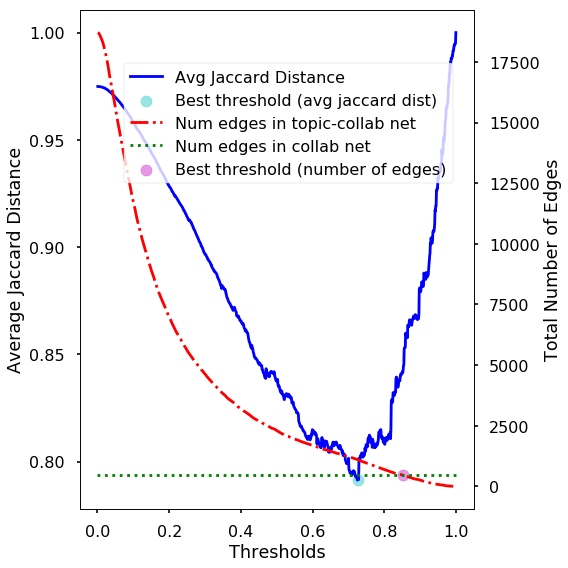

In [27]:
f = threshold_plot(
    thresholds,
    distances,
    edges,
    best_threshold,
    closest_edges,
    best_j_dist_threshold,
    lowest_avg_distances,
    adj_mat
)

In [28]:
f.savefig('./IMG/topicnetref20yr_thresholding.png', format='png', bbox_inches='tight')

####  As series of matrices:

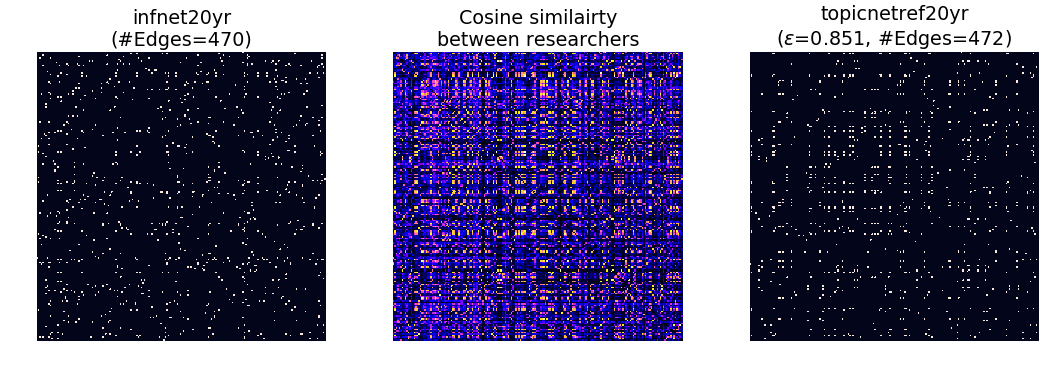

In [29]:
f = plt.figure(figsize=(15, 5))
# ORIGINAL COLALB NET
ax1 = f.add_subplot(131)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
ax1.set_title('infnet20yr\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
ax2 = f.add_subplot(132)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
ax3 = f.add_subplot(133)
ax3.axis('off')
sns.heatmap(topicnet_adj_mat, cbar=False, square=True, ax=ax3)
ax3.set_title('topicnetref20yr\n($\epsilon$={:.3f}, #Edges={})'.format(
    best_threshold,
    int(np.sum(topicnet_adj_mat) // 2)))

f.tight_layout()

In [30]:
f.savefig('./IMG/topicnetref20yr_adjmats.png')

#### As networks:

In [33]:
g_topicnetref20yr = adj_mat_to_graph(topicnet_adj_mat, collabnet.id.tolist())

In [34]:
print(nx.info(g_topicnetref20yr))

Name: 
Type: Graph
Number of nodes: 129
Number of edges: 472
Average degree:   7.3178


2018-03-30 23:31:37,081 : INFO : SAVE_GRAPHS: True


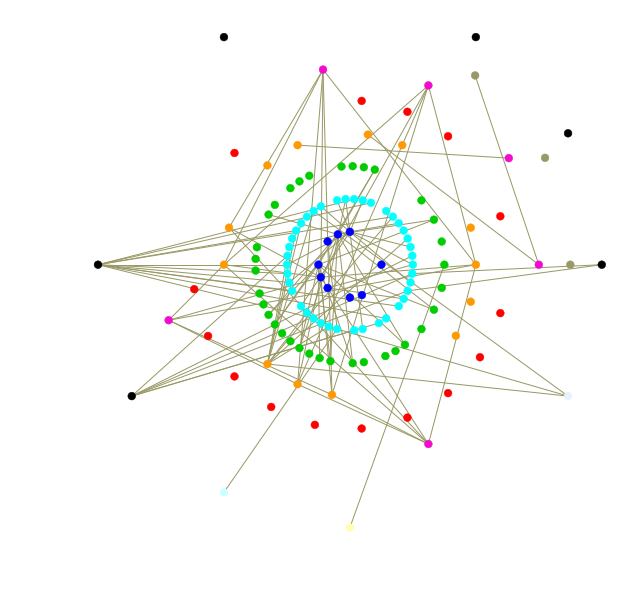

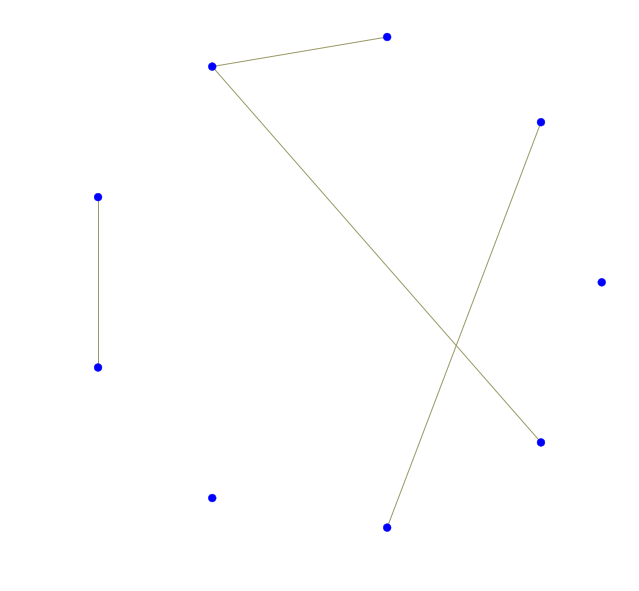

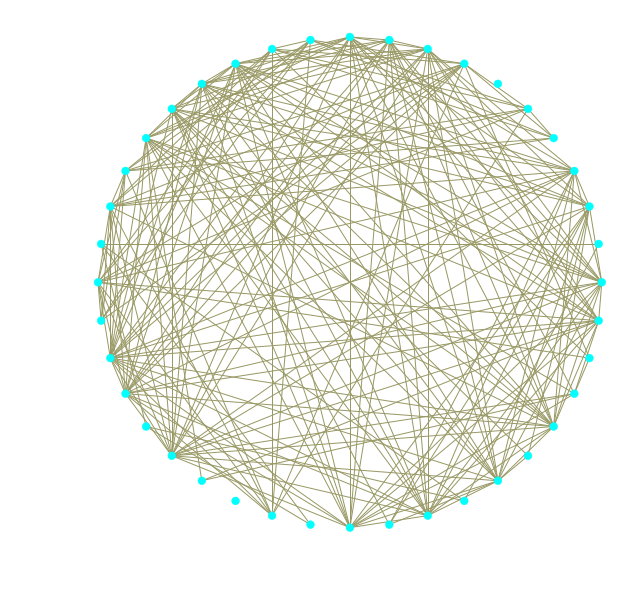

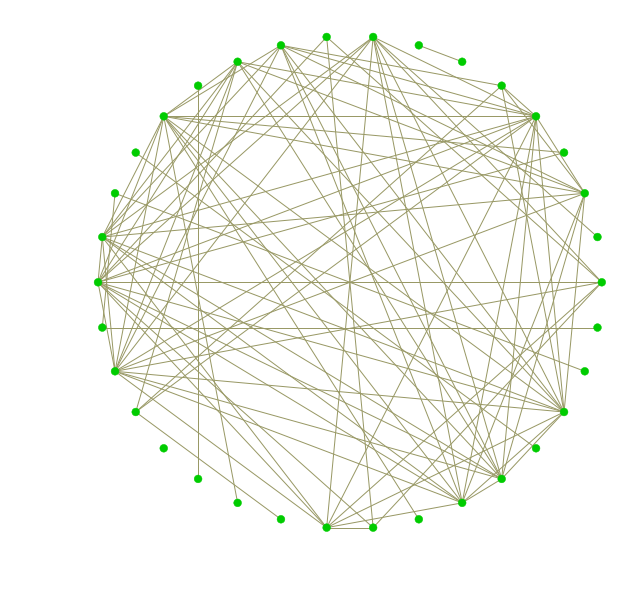

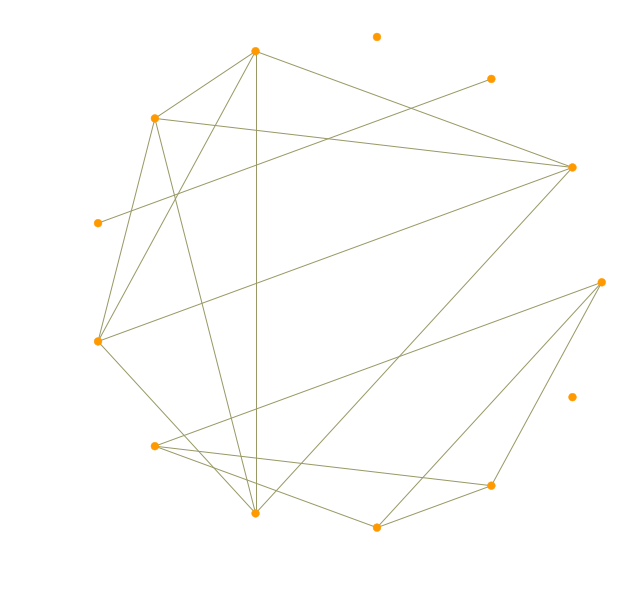

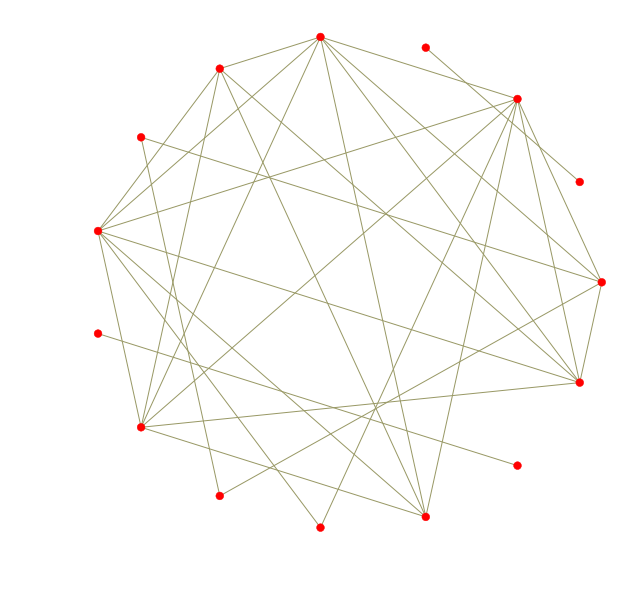

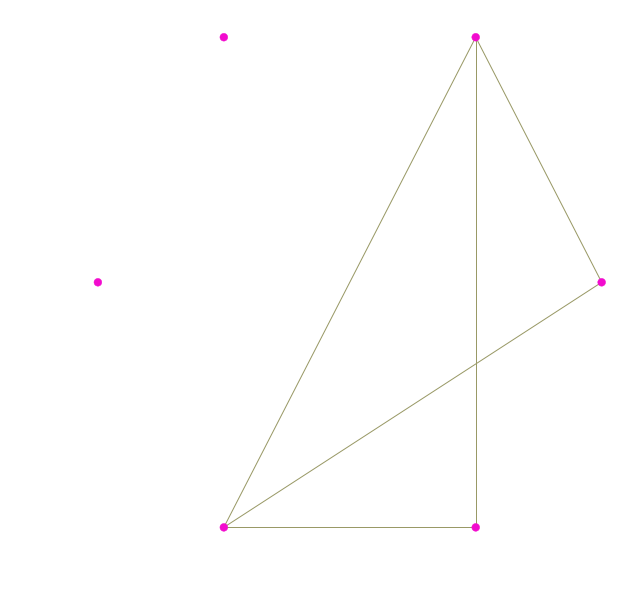

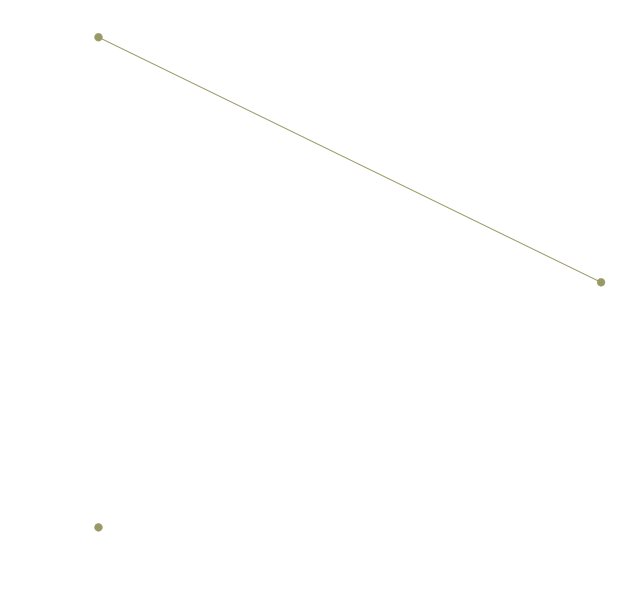

In [35]:
artist.draw_default_layout(
    g_topicnetref20yr,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='topicnetref20yr',
    SAVE_GRAPHS=True)

2018-03-30 23:31:47,491 : INFO : SAVE_GRAPHS: True


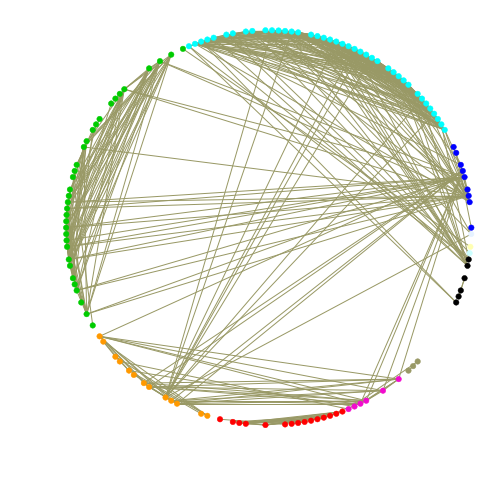

In [36]:
artist.draw_circular_layout(
    g_topicnetref20yr,
    get_lookup_poinf(),
    file_prefix='topicnetref20yr',
    SAVE_GRAPHS=True)

---
Embedding `infnet6yr`

## `topicnet-6yr`

### Deriving `topicnet-6yr`

In [6]:
# Filter out lookup table according to the tokens
lookup_combined_toks = prepare_toks(2012,2017)

In [7]:
# load collaboration network
collabnet = pd.read_csv(
    '../../data/data_schoolofinf/poinf_collabgraph_2012-2017.txt',
    sep='\n',
    names=['id'])
adj_mat = np.load('../../data/data_schoolofinf/mat/infnet6yrs-adj-mat.order6yr.pkl')

In [8]:
# Gather publications for each individuals
topicnet = collabnet.join(df_pubmapping.set_index('id'), how='left',on='id')
# generate tokens
topicnet['toks'] = topicnet['pub_ids'].apply(
    lambda a: gen_toks(a, lookup_combined_toks))

In [95]:
# load topic model
tm = models.LdaModel.load('../../topicModel/src/tmrest_meta/res/best_ldamodel')
dict_tm = Dictionary.load('../../data/data_schoolofinf/corpora/dictionary.less.meta')

2018-03-31 00:01:36,764 : INFO : loading LdaModel object from ../../topicModel/src/tmrest_meta/res/best_ldamodel
2018-03-31 00:01:36,808 : INFO : loading expElogbeta from ../../topicModel/src/tmrest_meta/res/best_ldamodel.expElogbeta.npy with mmap=None
2018-03-31 00:01:36,810 : INFO : setting ignored attribute dispatcher to None
2018-03-31 00:01:36,811 : INFO : setting ignored attribute state to None
2018-03-31 00:01:36,811 : INFO : setting ignored attribute id2word to None
2018-03-31 00:01:36,812 : INFO : loaded ../../topicModel/src/tmrest_meta/res/best_ldamodel
2018-03-31 00:01:36,812 : INFO : loading LdaModel object from ../../topicModel/src/tmrest_meta/res/best_ldamodel.state
2018-03-31 00:01:36,821 : INFO : loaded ../../topicModel/src/tmrest_meta/res/best_ldamodel.state
2018-03-31 00:01:36,838 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.less.meta
2018-03-31 00:01:36,841 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.less.m

In [96]:

# inference step by tm
topicnet['topic_probs'] = topicnet.toks.apply(
    lambda a: tm.get_document_topics(dict_tm.doc2bow(a)))

In [97]:
# Generate cosine sim between individuals
cosim = compare_researchers(topicnet.topic_probs.tolist(), tm.num_topics)

In [98]:
# find the best threshold:
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001)

2018-03-31 00:01:50,215 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.977 num_edges: 15767
2018-03-31 00:01:50,222 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.977 num_edges: 15576
2018-03-31 00:01:50,229 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.977 num_edges: 15371
2018-03-31 00:01:50,235 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.976 num_edges: 15202
2018-03-31 00:01:50,242 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.976 num_edges: 14993
2018-03-31 00:01:50,248 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.976 num_edges: 14844
2018-03-31 00:01:50,255 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.975 num_edges: 14701
2018-03-31 00:01:50,261 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.975 num_edges: 14537
2018-03-31 00:01:50,268 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.975 num_edges: 14378
2018-03-31 00:01:50,274 : INFO : epoch 9: threshold: 0.010 avg_dist: 0.974 num_edges: 14256
2018-03-31 00:01:50,282 : INFO : epoch 10: threshold: 0.011 avg_dist: 0.974 num_

2018-03-31 00:01:50,826 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.950 num_edges: 8017
2018-03-31 00:01:50,832 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.950 num_edges: 7984
2018-03-31 00:01:50,839 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.949 num_edges: 7951
2018-03-31 00:01:50,846 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.949 num_edges: 7903
2018-03-31 00:01:50,853 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.949 num_edges: 7855
2018-03-31 00:01:50,860 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.948 num_edges: 7815
2018-03-31 00:01:50,867 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.948 num_edges: 7771
2018-03-31 00:01:50,874 : INFO : epoch 96: threshold: 0.097 avg_dist: 0.948 num_edges: 7726
2018-03-31 00:01:50,881 : INFO : epoch 97: threshold: 0.098 avg_dist: 0.947 num_edges: 7679
2018-03-31 00:01:50,887 : INFO : epoch 98: threshold: 0.099 avg_dist: 0.947 num_edges: 7641
2018-03-31 00:01:50,895 : INFO : epoch 99: threshold: 0.100 avg_dist: 0.947 num_

2018-03-31 00:01:51,440 : INFO : epoch 177: threshold: 0.178 avg_dist: 0.925 num_edges: 5182
2018-03-31 00:01:51,447 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.925 num_edges: 5155
2018-03-31 00:01:51,454 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.924 num_edges: 5139
2018-03-31 00:01:51,461 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.924 num_edges: 5119
2018-03-31 00:01:51,468 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.924 num_edges: 5105
2018-03-31 00:01:51,475 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.923 num_edges: 5091
2018-03-31 00:01:51,482 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.923 num_edges: 5069
2018-03-31 00:01:51,489 : INFO : epoch 184: threshold: 0.185 avg_dist: 0.923 num_edges: 5051
2018-03-31 00:01:51,496 : INFO : epoch 185: threshold: 0.186 avg_dist: 0.923 num_edges: 5034
2018-03-31 00:01:51,503 : INFO : epoch 186: threshold: 0.187 avg_dist: 0.922 num_edges: 5012
2018-03-31 00:01:51,510 : INFO : epoch 187: threshold: 0.188 avg_dist:

2018-03-31 00:01:52,050 : INFO : epoch 265: threshold: 0.266 avg_dist: 0.901 num_edges: 3666
2018-03-31 00:01:52,057 : INFO : epoch 266: threshold: 0.267 avg_dist: 0.901 num_edges: 3653
2018-03-31 00:01:52,064 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.900 num_edges: 3646
2018-03-31 00:01:52,071 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.900 num_edges: 3628
2018-03-31 00:01:52,077 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.900 num_edges: 3616
2018-03-31 00:01:52,084 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.899 num_edges: 3598
2018-03-31 00:01:52,090 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.899 num_edges: 3585
2018-03-31 00:01:52,098 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.899 num_edges: 3578
2018-03-31 00:01:52,106 : INFO : epoch 273: threshold: 0.274 avg_dist: 0.898 num_edges: 3565
2018-03-31 00:01:52,112 : INFO : epoch 274: threshold: 0.275 avg_dist: 0.898 num_edges: 3549
2018-03-31 00:01:52,119 : INFO : epoch 275: threshold: 0.276 avg_dist:

2018-03-31 00:01:52,655 : INFO : epoch 353: threshold: 0.354 avg_dist: 0.875 num_edges: 2651
2018-03-31 00:01:52,662 : INFO : epoch 354: threshold: 0.355 avg_dist: 0.874 num_edges: 2646
2018-03-31 00:01:52,669 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.874 num_edges: 2633
2018-03-31 00:01:52,676 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.874 num_edges: 2623
2018-03-31 00:01:52,682 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.874 num_edges: 2618
2018-03-31 00:01:52,690 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.873 num_edges: 2608
2018-03-31 00:01:52,696 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.873 num_edges: 2599
2018-03-31 00:01:52,703 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.872 num_edges: 2594
2018-03-31 00:01:52,710 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.872 num_edges: 2588
2018-03-31 00:01:52,717 : INFO : epoch 362: threshold: 0.363 avg_dist: 0.872 num_edges: 2582
2018-03-31 00:01:52,771 : INFO : epoch 363: threshold: 0.364 avg_dist:

2018-03-31 00:01:53,303 : INFO : epoch 441: threshold: 0.442 avg_dist: 0.849 num_edges: 1937
2018-03-31 00:01:53,310 : INFO : epoch 442: threshold: 0.443 avg_dist: 0.849 num_edges: 1933
2018-03-31 00:01:53,317 : INFO : epoch 443: threshold: 0.444 avg_dist: 0.848 num_edges: 1923
2018-03-31 00:01:53,325 : INFO : epoch 444: threshold: 0.445 avg_dist: 0.847 num_edges: 1916
2018-03-31 00:01:53,332 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.847 num_edges: 1906
2018-03-31 00:01:53,339 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.846 num_edges: 1894
2018-03-31 00:01:53,345 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.846 num_edges: 1889
2018-03-31 00:01:53,353 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.845 num_edges: 1879
2018-03-31 00:01:53,360 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.845 num_edges: 1873
2018-03-31 00:01:53,367 : INFO : epoch 450: threshold: 0.451 avg_dist: 0.845 num_edges: 1868
2018-03-31 00:01:53,374 : INFO : epoch 451: threshold: 0.452 avg_dist:

2018-03-31 00:01:53,936 : INFO : epoch 530: threshold: 0.531 avg_dist: 0.824 num_edges: 1412
2018-03-31 00:01:53,944 : INFO : epoch 531: threshold: 0.532 avg_dist: 0.826 num_edges: 1407
2018-03-31 00:01:53,952 : INFO : epoch 532: threshold: 0.533 avg_dist: 0.827 num_edges: 1401
2018-03-31 00:01:53,959 : INFO : epoch 533: threshold: 0.534 avg_dist: 0.826 num_edges: 1392
2018-03-31 00:01:53,965 : INFO : epoch 534: threshold: 0.535 avg_dist: 0.827 num_edges: 1390
2018-03-31 00:01:53,972 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.826 num_edges: 1383
2018-03-31 00:01:53,978 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.825 num_edges: 1377
2018-03-31 00:01:53,985 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.824 num_edges: 1368
2018-03-31 00:01:53,991 : INFO : epoch 538: threshold: 0.539 avg_dist: 0.824 num_edges: 1361
2018-03-31 00:01:53,998 : INFO : epoch 539: threshold: 0.540 avg_dist: 0.823 num_edges: 1356
2018-03-31 00:01:54,004 : INFO : epoch 540: threshold: 0.541 avg_dist:

2018-03-31 00:01:54,601 : INFO : epoch 619: threshold: 0.620 avg_dist: 0.797 num_edges: 999
2018-03-31 00:01:54,607 : INFO : epoch 620: threshold: 0.621 avg_dist: 0.799 num_edges: 997
2018-03-31 00:01:54,614 : INFO : epoch 621: threshold: 0.622 avg_dist: 0.800 num_edges: 995
2018-03-31 00:01:54,620 : INFO : epoch 622: threshold: 0.623 avg_dist: 0.800 num_edges: 993
2018-03-31 00:01:54,627 : INFO : epoch 623: threshold: 0.624 avg_dist: 0.799 num_edges: 991
2018-03-31 00:01:54,634 : INFO : epoch 624: threshold: 0.625 avg_dist: 0.799 num_edges: 987
2018-03-31 00:01:54,640 : INFO : epoch 625: threshold: 0.626 avg_dist: 0.798 num_edges: 984
2018-03-31 00:01:54,646 : INFO : epoch 626: threshold: 0.627 avg_dist: 0.797 num_edges: 979
2018-03-31 00:01:54,653 : INFO : epoch 627: threshold: 0.628 avg_dist: 0.797 num_edges: 976
2018-03-31 00:01:54,660 : INFO : epoch 628: threshold: 0.629 avg_dist: 0.797 num_edges: 974
2018-03-31 00:01:54,666 : INFO : epoch 629: threshold: 0.630 avg_dist: 0.798 num

2018-03-31 00:01:55,204 : INFO : epoch 709: threshold: 0.710 avg_dist: 0.770 num_edges: 677
2018-03-31 00:01:55,211 : INFO : epoch 710: threshold: 0.711 avg_dist: 0.769 num_edges: 672
2018-03-31 00:01:55,218 : INFO : epoch 711: threshold: 0.712 avg_dist: 0.769 num_edges: 670
2018-03-31 00:01:55,225 : INFO : epoch 712: threshold: 0.713 avg_dist: 0.770 num_edges: 667
2018-03-31 00:01:55,232 : INFO : epoch 713: threshold: 0.714 avg_dist: 0.770 num_edges: 666
2018-03-31 00:01:55,238 : INFO : epoch 714: threshold: 0.715 avg_dist: 0.772 num_edges: 657
2018-03-31 00:01:55,244 : INFO : epoch 715: threshold: 0.716 avg_dist: 0.777 num_edges: 648
2018-03-31 00:01:55,251 : INFO : epoch 716: threshold: 0.717 avg_dist: 0.774 num_edges: 645
2018-03-31 00:01:55,258 : INFO : epoch 717: threshold: 0.718 avg_dist: 0.775 num_edges: 639
2018-03-31 00:01:55,264 : INFO : epoch 718: threshold: 0.719 avg_dist: 0.774 num_edges: 636
2018-03-31 00:01:55,270 : INFO : epoch 719: threshold: 0.720 avg_dist: 0.774 num

2018-03-31 00:01:55,866 : INFO : epoch 799: threshold: 0.800 avg_dist: 0.781 num_edges: 416
2018-03-31 00:01:55,872 : INFO : epoch 800: threshold: 0.801 avg_dist: 0.780 num_edges: 415
2018-03-31 00:01:55,879 : INFO : epoch 801: threshold: 0.802 avg_dist: 0.781 num_edges: 413
2018-03-31 00:01:55,886 : INFO : epoch 802: threshold: 0.803 avg_dist: 0.782 num_edges: 408
2018-03-31 00:01:55,893 : INFO : epoch 803: threshold: 0.804 avg_dist: 0.784 num_edges: 407
2018-03-31 00:01:55,899 : INFO : epoch 804: threshold: 0.805 avg_dist: 0.784 num_edges: 405
2018-03-31 00:01:55,906 : INFO : epoch 805: threshold: 0.806 avg_dist: 0.784 num_edges: 404
2018-03-31 00:01:55,912 : INFO : epoch 806: threshold: 0.807 avg_dist: 0.784 num_edges: 404
2018-03-31 00:01:55,919 : INFO : epoch 807: threshold: 0.808 avg_dist: 0.783 num_edges: 403
2018-03-31 00:01:55,925 : INFO : epoch 808: threshold: 0.809 avg_dist: 0.781 num_edges: 399
2018-03-31 00:01:55,933 : INFO : epoch 809: threshold: 0.810 avg_dist: 0.783 num

2018-03-31 00:01:56,457 : INFO : epoch 888: threshold: 0.889 avg_dist: 0.836 num_edges: 238
2018-03-31 00:01:56,463 : INFO : epoch 889: threshold: 0.890 avg_dist: 0.838 num_edges: 237
2018-03-31 00:01:56,469 : INFO : epoch 890: threshold: 0.891 avg_dist: 0.838 num_edges: 237
2018-03-31 00:01:56,476 : INFO : epoch 891: threshold: 0.892 avg_dist: 0.841 num_edges: 234
2018-03-31 00:01:56,482 : INFO : epoch 892: threshold: 0.893 avg_dist: 0.841 num_edges: 231
2018-03-31 00:01:56,489 : INFO : epoch 893: threshold: 0.894 avg_dist: 0.844 num_edges: 227
2018-03-31 00:01:56,496 : INFO : epoch 894: threshold: 0.895 avg_dist: 0.845 num_edges: 225
2018-03-31 00:01:56,503 : INFO : epoch 895: threshold: 0.896 avg_dist: 0.845 num_edges: 223
2018-03-31 00:01:56,509 : INFO : epoch 896: threshold: 0.897 avg_dist: 0.848 num_edges: 222
2018-03-31 00:01:56,516 : INFO : epoch 897: threshold: 0.898 avg_dist: 0.851 num_edges: 220
2018-03-31 00:01:56,523 : INFO : epoch 898: threshold: 0.899 avg_dist: 0.852 num

2018-03-31 00:01:57,113 : INFO : epoch 978: threshold: 0.979 avg_dist: 0.951 num_edges: 38
2018-03-31 00:01:57,120 : INFO : epoch 979: threshold: 0.980 avg_dist: 0.955 num_edges: 35
2018-03-31 00:01:57,127 : INFO : epoch 980: threshold: 0.981 avg_dist: 0.957 num_edges: 31
2018-03-31 00:01:57,134 : INFO : epoch 981: threshold: 0.982 avg_dist: 0.958 num_edges: 28
2018-03-31 00:01:57,140 : INFO : epoch 982: threshold: 0.983 avg_dist: 0.957 num_edges: 26
2018-03-31 00:01:57,147 : INFO : epoch 983: threshold: 0.984 avg_dist: 0.957 num_edges: 22
2018-03-31 00:01:57,154 : INFO : epoch 984: threshold: 0.985 avg_dist: 0.956 num_edges: 21
2018-03-31 00:01:57,161 : INFO : epoch 985: threshold: 0.986 avg_dist: 0.959 num_edges: 19
2018-03-31 00:01:57,167 : INFO : epoch 986: threshold: 0.987 avg_dist: 0.959 num_edges: 19
2018-03-31 00:01:57,173 : INFO : epoch 987: threshold: 0.988 avg_dist: 0.964 num_edges: 17
2018-03-31 00:01:57,179 : INFO : epoch 988: threshold: 0.989 avg_dist: 0.964 num_edges: 17

threshold: 0.826 dist 0.768529 (711, 0.712) edges 360/360.0 (825)


threshold: 0.826 dist 0.768529 (711, 0.712) edges 360/360.0 (825)

In [45]:
# Set the edges:
topicnet_adj_mat = set_edges(cosim, best_threshold, binary=True)
topicnet_adj_mat.dump('./res/topicnet6yr_adjmat.pkl')

2018-03-30 23:34:03,640 : INFO : dimension: 183, 183


### Visualise

#### Thresholding:

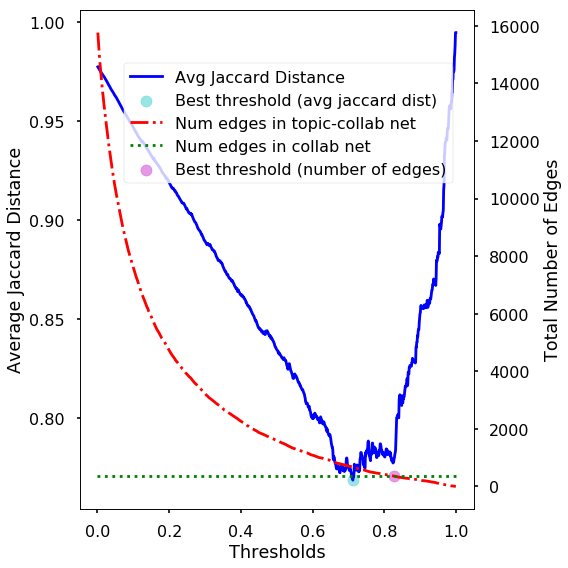

In [46]:
f = threshold_plot(
    thresholds,
    distances,
    edges,
    best_threshold,
    closest_edges,
    best_j_dist_threshold,
    lowest_avg_distances,
    adj_mat
)

In [47]:
f.savefig('./IMG/topicnet6yr_thresholding.png', format='png', bbox_inches='tight')

####  As series of matrices:

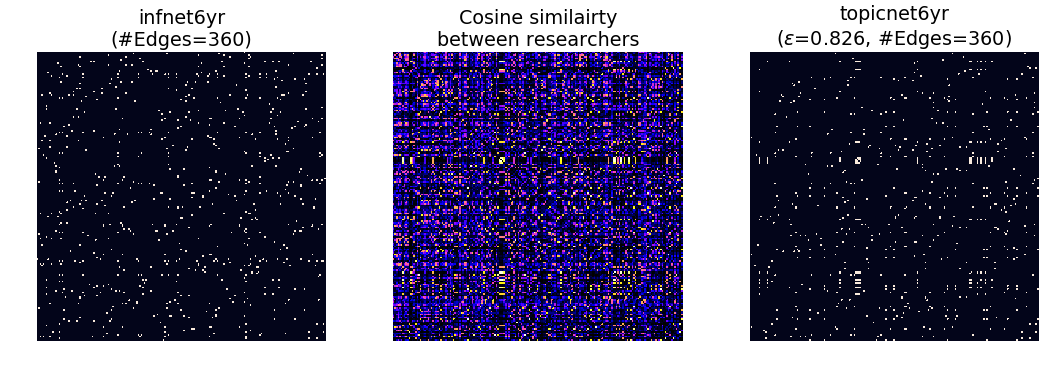

In [48]:
f = plt.figure(figsize=(15, 5))
# ORIGINAL COLALB NET
ax1 = f.add_subplot(131)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
ax1.set_title('infnet6yr\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
ax2 = f.add_subplot(132)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
ax3 = f.add_subplot(133)
ax3.axis('off')
sns.heatmap(topicnet_adj_mat, cbar=False, square=True, ax=ax3)
ax3.set_title('topicnet6yr\n($\epsilon$={:.3f}, #Edges={})'.format(
    best_threshold,
    int(np.sum(topicnet_adj_mat) // 2)))

f.tight_layout()

In [49]:
f.savefig('./IMG/topicnet6yr_adjmats.png')

#### As networks:

In [51]:
g_topicnet6yr = adj_mat_to_graph(topicnet_adj_mat, collabnet.id.tolist())

In [52]:
print(nx.info(g_topicnet6yr))

Name: 
Type: Graph
Number of nodes: 151
Number of edges: 360
Average degree:   4.7682


2018-03-30 23:34:47,079 : INFO : SAVE_GRAPHS: True


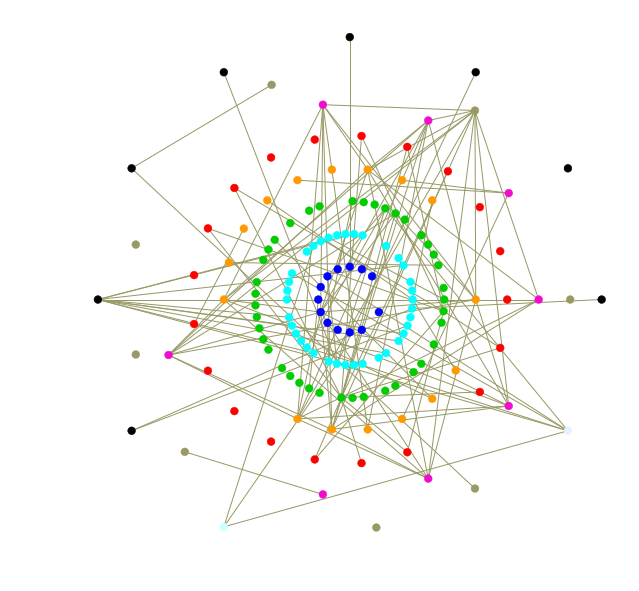

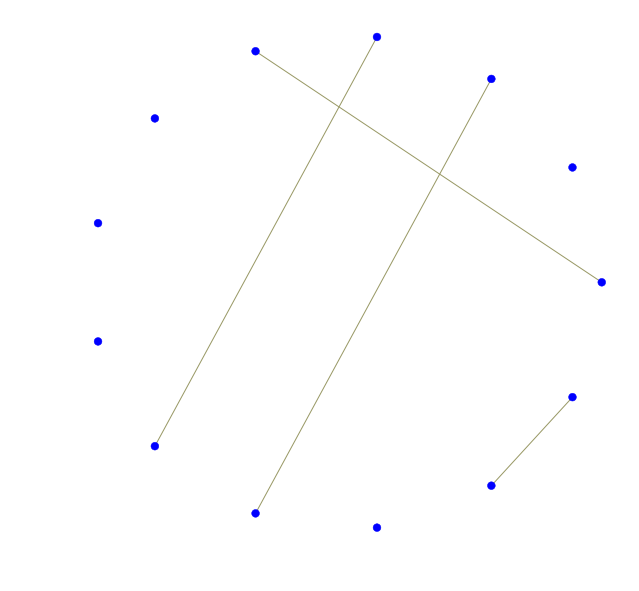

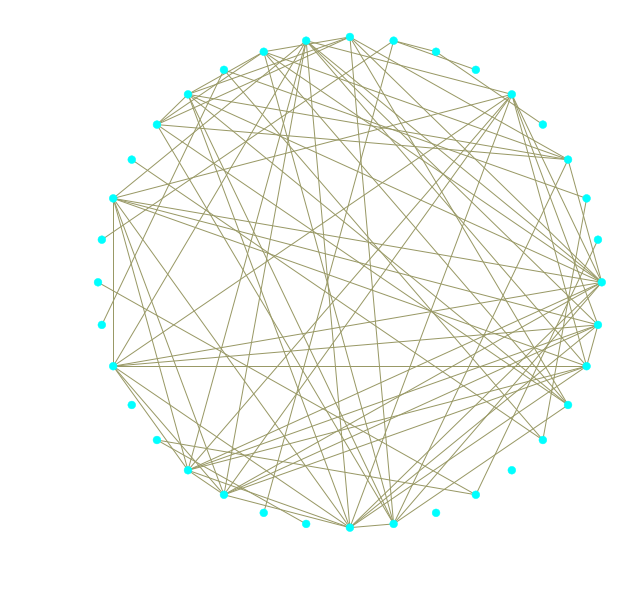

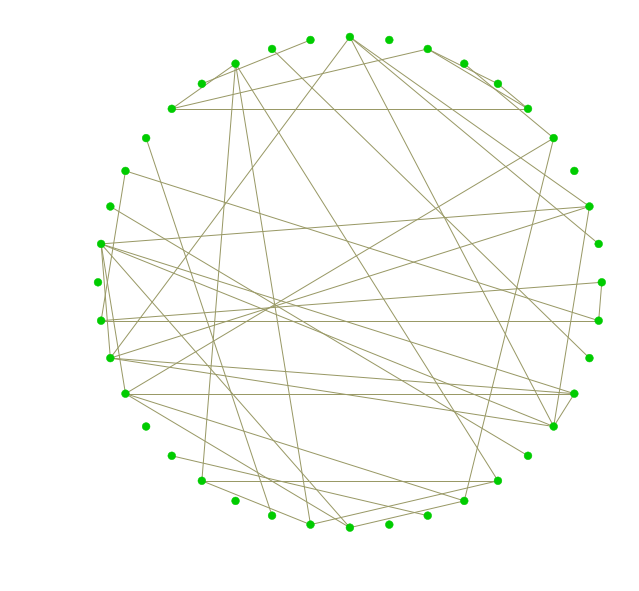

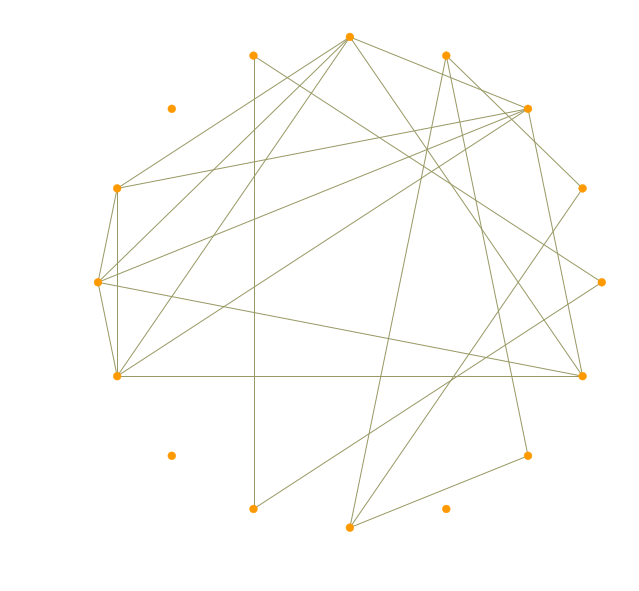

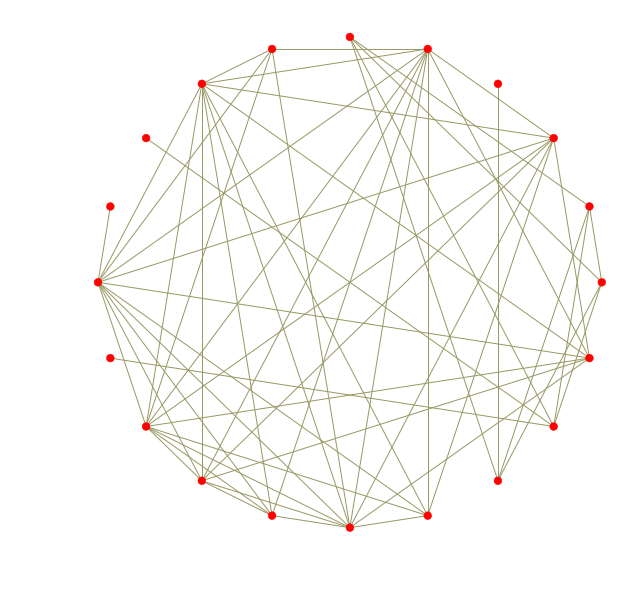

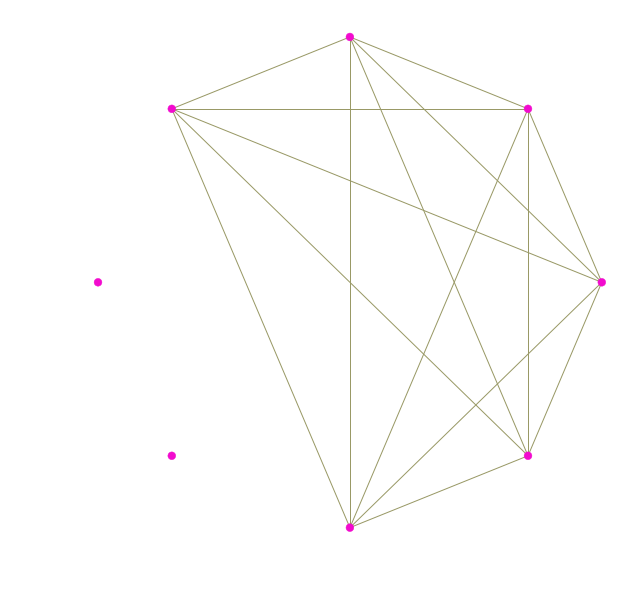

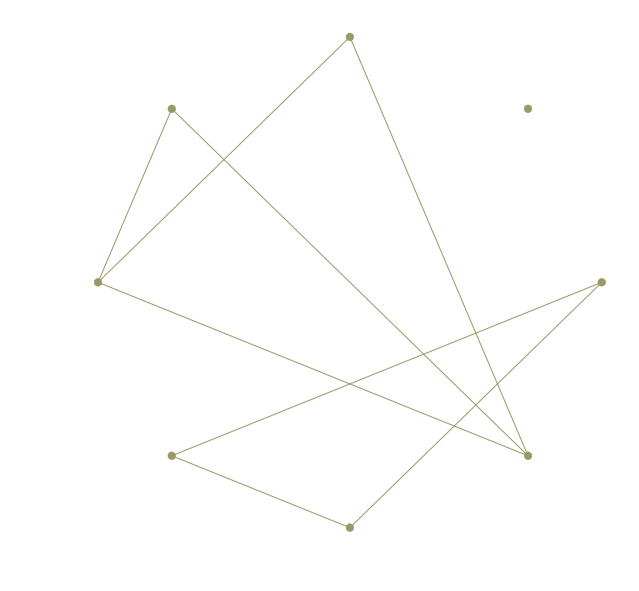

In [53]:
artist.draw_default_layout(
    g_topicnet6yr,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='topicnet6yr',
    SAVE_GRAPHS=True)

2018-03-30 23:34:59,743 : INFO : SAVE_GRAPHS: True


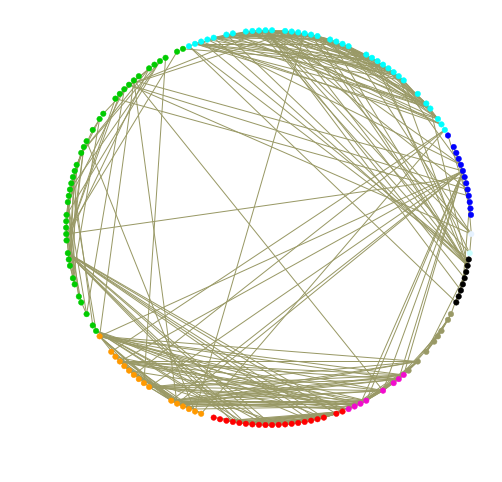

In [54]:
artist.draw_circular_layout(
    g_topicnet6yr,
    get_lookup_poinf(),
    file_prefix='topicnet6yr',
    SAVE_GRAPHS=True)

## `topicnetref-6yr`

### Deriving `topicnetref-6yr`

In [9]:
# Since we are using the same base, we do not need to reload it again!
# Loading the new topic model:
tm = models.LdaModel.load('../../topicModel/src/tmdblp/tm_dblp')
dict_tm = Dictionary.load(
    '../../data/data_dblp/corpora/dictionary.dblp.1997-2017')

2018-03-31 00:35:20,273 : INFO : loading LdaModel object from ../../topicModel/src/tmdblp/tm_dblp
2018-03-31 00:35:20,325 : INFO : loading expElogbeta from ../../topicModel/src/tmdblp/tm_dblp.expElogbeta.npy with mmap=None
2018-03-31 00:35:20,901 : INFO : setting ignored attribute id2word to None
2018-03-31 00:35:20,902 : INFO : setting ignored attribute dispatcher to None
2018-03-31 00:35:20,903 : INFO : setting ignored attribute state to None
2018-03-31 00:35:20,903 : INFO : loaded ../../topicModel/src/tmdblp/tm_dblp
2018-03-31 00:35:20,904 : INFO : loading LdaModel object from ../../topicModel/src/tmdblp/tm_dblp.state
2018-03-31 00:35:22,079 : INFO : loaded ../../topicModel/src/tmdblp/tm_dblp.state
2018-03-31 00:35:22,162 : INFO : loading Dictionary object from ../../data/data_dblp/corpora/dictionary.dblp.1997-2017
2018-03-31 00:35:22,220 : INFO : loaded ../../data/data_dblp/corpora/dictionary.dblp.1997-2017


In [10]:
# Generate topic probabilities for each publication using the dictionary for DBLP
tm.minimum_probability = 0.001
topicnet['topic_probs'] = topicnet.toks.apply(
    lambda a: tm.get_document_topics(dict_tm.doc2bow(a)) if len(a) else None)

In [11]:
# Generate cosine similarity
cosim = compare_researchers(topicnet.topic_probs.tolist(), tm.num_topics)

In [58]:
# find best threshold
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001)

2018-03-30 23:35:26,085 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.978 num_edges: 16622
2018-03-30 23:35:26,092 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.978 num_edges: 16609
2018-03-30 23:35:26,099 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.978 num_edges: 16595
2018-03-30 23:35:26,105 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.978 num_edges: 16567
2018-03-30 23:35:26,112 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.978 num_edges: 16532
2018-03-30 23:35:26,118 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.978 num_edges: 16508
2018-03-30 23:35:26,125 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.978 num_edges: 16477
2018-03-30 23:35:26,131 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.978 num_edges: 16434
2018-03-30 23:35:26,137 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.978 num_edges: 16388
2018-03-30 23:35:26,144 : INFO : epoch 9: threshold: 0.010 avg_dist: 0.978 num_edges: 16344
2018-03-30 23:35:26,150 : INFO : epoch 10: threshold: 0.011 avg_dist: 0.978 num_

2018-03-30 23:35:26,694 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.963 num_edges: 10504
2018-03-30 23:35:26,702 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.963 num_edges: 10453
2018-03-30 23:35:26,709 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.962 num_edges: 10392
2018-03-30 23:35:26,716 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.962 num_edges: 10329
2018-03-30 23:35:26,723 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.962 num_edges: 10281
2018-03-30 23:35:26,729 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.962 num_edges: 10220
2018-03-30 23:35:26,736 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.961 num_edges: 10169
2018-03-30 23:35:26,743 : INFO : epoch 96: threshold: 0.097 avg_dist: 0.961 num_edges: 10104
2018-03-30 23:35:26,749 : INFO : epoch 97: threshold: 0.098 avg_dist: 0.961 num_edges: 10049
2018-03-30 23:35:26,756 : INFO : epoch 98: threshold: 0.099 avg_dist: 0.961 num_edges: 9985
2018-03-30 23:35:26,763 : INFO : epoch 99: threshold: 0.100 avg_dist: 0

2018-03-30 23:35:27,313 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.939 num_edges: 6600
2018-03-30 23:35:27,321 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.939 num_edges: 6571
2018-03-30 23:35:27,329 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.939 num_edges: 6540
2018-03-30 23:35:27,336 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.938 num_edges: 6503
2018-03-30 23:35:27,343 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.938 num_edges: 6469
2018-03-30 23:35:27,349 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.937 num_edges: 6432
2018-03-30 23:35:27,356 : INFO : epoch 184: threshold: 0.185 avg_dist: 0.937 num_edges: 6412
2018-03-30 23:35:27,362 : INFO : epoch 185: threshold: 0.186 avg_dist: 0.937 num_edges: 6374
2018-03-30 23:35:27,370 : INFO : epoch 186: threshold: 0.187 avg_dist: 0.937 num_edges: 6340
2018-03-30 23:35:27,377 : INFO : epoch 187: threshold: 0.188 avg_dist: 0.936 num_edges: 6303
2018-03-30 23:35:27,384 : INFO : epoch 188: threshold: 0.189 avg_dist:

2018-03-30 23:35:27,929 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.912 num_edges: 4404
2018-03-30 23:35:27,937 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.911 num_edges: 4386
2018-03-30 23:35:27,944 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.911 num_edges: 4363
2018-03-30 23:35:27,951 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.910 num_edges: 4339
2018-03-30 23:35:27,958 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.910 num_edges: 4326
2018-03-30 23:35:27,966 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.910 num_edges: 4307
2018-03-30 23:35:27,972 : INFO : epoch 273: threshold: 0.274 avg_dist: 0.910 num_edges: 4288
2018-03-30 23:35:27,979 : INFO : epoch 274: threshold: 0.275 avg_dist: 0.909 num_edges: 4269
2018-03-30 23:35:27,986 : INFO : epoch 275: threshold: 0.276 avg_dist: 0.909 num_edges: 4257
2018-03-30 23:35:27,993 : INFO : epoch 276: threshold: 0.277 avg_dist: 0.908 num_edges: 4236
2018-03-30 23:35:27,999 : INFO : epoch 277: threshold: 0.278 avg_dist:

2018-03-30 23:35:28,540 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.881 num_edges: 3132
2018-03-30 23:35:28,548 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.880 num_edges: 3122
2018-03-30 23:35:28,554 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.880 num_edges: 3107
2018-03-30 23:35:28,561 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.879 num_edges: 3098
2018-03-30 23:35:28,569 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.879 num_edges: 3084
2018-03-30 23:35:28,575 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.878 num_edges: 3067
2018-03-30 23:35:28,583 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.878 num_edges: 3055
2018-03-30 23:35:28,590 : INFO : epoch 362: threshold: 0.363 avg_dist: 0.877 num_edges: 3040
2018-03-30 23:35:28,597 : INFO : epoch 363: threshold: 0.364 avg_dist: 0.877 num_edges: 3027
2018-03-30 23:35:28,603 : INFO : epoch 364: threshold: 0.365 avg_dist: 0.877 num_edges: 3019
2018-03-30 23:35:28,610 : INFO : epoch 365: threshold: 0.366 avg_dist:

2018-03-30 23:35:29,229 : INFO : epoch 443: threshold: 0.444 avg_dist: 0.846 num_edges: 2208
2018-03-30 23:35:29,235 : INFO : epoch 444: threshold: 0.445 avg_dist: 0.845 num_edges: 2200
2018-03-30 23:35:29,243 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.845 num_edges: 2192
2018-03-30 23:35:29,250 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.845 num_edges: 2189
2018-03-30 23:35:29,256 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.845 num_edges: 2181
2018-03-30 23:35:29,263 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.845 num_edges: 2176
2018-03-30 23:35:29,270 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.846 num_edges: 2169
2018-03-30 23:35:29,277 : INFO : epoch 450: threshold: 0.451 avg_dist: 0.846 num_edges: 2162
2018-03-30 23:35:29,284 : INFO : epoch 451: threshold: 0.452 avg_dist: 0.845 num_edges: 2153
2018-03-30 23:35:29,291 : INFO : epoch 452: threshold: 0.453 avg_dist: 0.844 num_edges: 2141
2018-03-30 23:35:29,298 : INFO : epoch 453: threshold: 0.454 avg_dist:

2018-03-30 23:35:29,830 : INFO : epoch 531: threshold: 0.532 avg_dist: 0.815 num_edges: 1591
2018-03-30 23:35:29,837 : INFO : epoch 532: threshold: 0.533 avg_dist: 0.814 num_edges: 1589
2018-03-30 23:35:29,843 : INFO : epoch 533: threshold: 0.534 avg_dist: 0.814 num_edges: 1584
2018-03-30 23:35:29,850 : INFO : epoch 534: threshold: 0.535 avg_dist: 0.813 num_edges: 1581
2018-03-30 23:35:29,857 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.812 num_edges: 1577
2018-03-30 23:35:29,864 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.810 num_edges: 1565
2018-03-30 23:35:29,870 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.808 num_edges: 1555
2018-03-30 23:35:29,877 : INFO : epoch 538: threshold: 0.539 avg_dist: 0.807 num_edges: 1549
2018-03-30 23:35:29,884 : INFO : epoch 539: threshold: 0.540 avg_dist: 0.807 num_edges: 1546
2018-03-30 23:35:29,890 : INFO : epoch 540: threshold: 0.541 avg_dist: 0.806 num_edges: 1541
2018-03-30 23:35:29,897 : INFO : epoch 541: threshold: 0.542 avg_dist:

2018-03-30 23:35:30,487 : INFO : epoch 619: threshold: 0.620 avg_dist: 0.789 num_edges: 1164
2018-03-30 23:35:30,494 : INFO : epoch 620: threshold: 0.621 avg_dist: 0.790 num_edges: 1160
2018-03-30 23:35:30,500 : INFO : epoch 621: threshold: 0.622 avg_dist: 0.789 num_edges: 1155
2018-03-30 23:35:30,507 : INFO : epoch 622: threshold: 0.623 avg_dist: 0.788 num_edges: 1152
2018-03-30 23:35:30,514 : INFO : epoch 623: threshold: 0.624 avg_dist: 0.788 num_edges: 1145
2018-03-30 23:35:30,521 : INFO : epoch 624: threshold: 0.625 avg_dist: 0.788 num_edges: 1142
2018-03-30 23:35:30,528 : INFO : epoch 625: threshold: 0.626 avg_dist: 0.788 num_edges: 1135
2018-03-30 23:35:30,536 : INFO : epoch 626: threshold: 0.627 avg_dist: 0.787 num_edges: 1130
2018-03-30 23:35:30,543 : INFO : epoch 627: threshold: 0.628 avg_dist: 0.787 num_edges: 1124
2018-03-30 23:35:30,550 : INFO : epoch 628: threshold: 0.629 avg_dist: 0.786 num_edges: 1118
2018-03-30 23:35:30,556 : INFO : epoch 629: threshold: 0.630 avg_dist:

2018-03-30 23:35:31,084 : INFO : epoch 707: threshold: 0.708 avg_dist: 0.780 num_edges: 808
2018-03-30 23:35:31,091 : INFO : epoch 708: threshold: 0.709 avg_dist: 0.781 num_edges: 804
2018-03-30 23:35:31,097 : INFO : epoch 709: threshold: 0.710 avg_dist: 0.784 num_edges: 800
2018-03-30 23:35:31,104 : INFO : epoch 710: threshold: 0.711 avg_dist: 0.787 num_edges: 796
2018-03-30 23:35:31,110 : INFO : epoch 711: threshold: 0.712 avg_dist: 0.787 num_edges: 791
2018-03-30 23:35:31,118 : INFO : epoch 712: threshold: 0.713 avg_dist: 0.787 num_edges: 787
2018-03-30 23:35:31,124 : INFO : epoch 713: threshold: 0.714 avg_dist: 0.787 num_edges: 786
2018-03-30 23:35:31,132 : INFO : epoch 714: threshold: 0.715 avg_dist: 0.784 num_edges: 782
2018-03-30 23:35:31,138 : INFO : epoch 715: threshold: 0.716 avg_dist: 0.782 num_edges: 778
2018-03-30 23:35:31,145 : INFO : epoch 716: threshold: 0.717 avg_dist: 0.780 num_edges: 775
2018-03-30 23:35:31,152 : INFO : epoch 717: threshold: 0.718 avg_dist: 0.781 num

2018-03-30 23:35:31,680 : INFO : epoch 796: threshold: 0.797 avg_dist: 0.796 num_edges: 461
2018-03-30 23:35:31,686 : INFO : epoch 797: threshold: 0.798 avg_dist: 0.796 num_edges: 454
2018-03-30 23:35:31,693 : INFO : epoch 798: threshold: 0.799 avg_dist: 0.795 num_edges: 451
2018-03-30 23:35:31,701 : INFO : epoch 799: threshold: 0.800 avg_dist: 0.796 num_edges: 448
2018-03-30 23:35:31,707 : INFO : epoch 800: threshold: 0.801 avg_dist: 0.795 num_edges: 446
2018-03-30 23:35:31,713 : INFO : epoch 801: threshold: 0.802 avg_dist: 0.795 num_edges: 444
2018-03-30 23:35:31,720 : INFO : epoch 802: threshold: 0.803 avg_dist: 0.795 num_edges: 443
2018-03-30 23:35:31,727 : INFO : epoch 803: threshold: 0.804 avg_dist: 0.794 num_edges: 440
2018-03-30 23:35:31,734 : INFO : epoch 804: threshold: 0.805 avg_dist: 0.794 num_edges: 435
2018-03-30 23:35:31,740 : INFO : epoch 805: threshold: 0.806 avg_dist: 0.793 num_edges: 432
2018-03-30 23:35:31,747 : INFO : epoch 806: threshold: 0.807 avg_dist: 0.797 num

2018-03-30 23:35:32,347 : INFO : epoch 886: threshold: 0.887 avg_dist: 0.849 num_edges: 207
2018-03-30 23:35:32,354 : INFO : epoch 887: threshold: 0.888 avg_dist: 0.849 num_edges: 206
2018-03-30 23:35:32,360 : INFO : epoch 888: threshold: 0.889 avg_dist: 0.852 num_edges: 203
2018-03-30 23:35:32,367 : INFO : epoch 889: threshold: 0.890 avg_dist: 0.851 num_edges: 201
2018-03-30 23:35:32,374 : INFO : epoch 890: threshold: 0.891 avg_dist: 0.851 num_edges: 200
2018-03-30 23:35:32,380 : INFO : epoch 891: threshold: 0.892 avg_dist: 0.852 num_edges: 196
2018-03-30 23:35:32,387 : INFO : epoch 892: threshold: 0.893 avg_dist: 0.851 num_edges: 194
2018-03-30 23:35:32,394 : INFO : epoch 893: threshold: 0.894 avg_dist: 0.851 num_edges: 191
2018-03-30 23:35:32,401 : INFO : epoch 894: threshold: 0.895 avg_dist: 0.851 num_edges: 190
2018-03-30 23:35:32,407 : INFO : epoch 895: threshold: 0.896 avg_dist: 0.851 num_edges: 187
2018-03-30 23:35:32,414 : INFO : epoch 896: threshold: 0.897 avg_dist: 0.862 num

2018-03-30 23:35:32,946 : INFO : epoch 976: threshold: 0.977 avg_dist: 0.963 num_edges: 21
2018-03-30 23:35:32,953 : INFO : epoch 977: threshold: 0.978 avg_dist: 0.963 num_edges: 20
2018-03-30 23:35:32,960 : INFO : epoch 978: threshold: 0.979 avg_dist: 0.965 num_edges: 19
2018-03-30 23:35:32,967 : INFO : epoch 979: threshold: 0.980 avg_dist: 0.968 num_edges: 17
2018-03-30 23:35:32,973 : INFO : epoch 980: threshold: 0.981 avg_dist: 0.968 num_edges: 17
2018-03-30 23:35:32,980 : INFO : epoch 981: threshold: 0.982 avg_dist: 0.970 num_edges: 16
2018-03-30 23:35:32,986 : INFO : epoch 982: threshold: 0.983 avg_dist: 0.976 num_edges: 15
2018-03-30 23:35:32,994 : INFO : epoch 983: threshold: 0.984 avg_dist: 0.981 num_edges: 12
2018-03-30 23:35:33,000 : INFO : epoch 984: threshold: 0.985 avg_dist: 0.981 num_edges: 12
2018-03-30 23:35:33,006 : INFO : epoch 985: threshold: 0.986 avg_dist: 0.981 num_edges: 12
2018-03-30 23:35:33,013 : INFO : epoch 986: threshold: 0.987 avg_dist: 0.982 num_edges: 10

threshold: 0.832 dist 0.767666 (672, 0.673) edges 361/360.0 (831)


threshold: 0.832 dist 0.767666 (672, 0.673) edges 361/360.0 (831)

In [60]:
# Set the edges:
topicnet_adj_mat = set_edges(cosim, best_threshold, binary=True)
topicnet_adj_mat.dump('./res/topicnetref6yr_adjmat.pkl')

2018-03-30 23:35:57,992 : INFO : dimension: 183, 183


### Visualise

#### Thresholding:

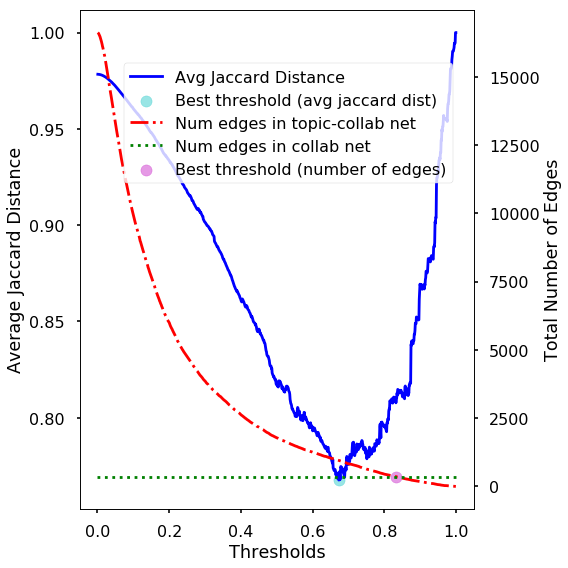

In [61]:
f = threshold_plot(
    thresholds,
    distances,
    edges,
    best_threshold,
    closest_edges,
    best_j_dist_threshold,
    lowest_avg_distances,
    adj_mat
)

In [62]:
f.savefig(
    './IMG/topicnetref6yr_thresholding.png', format='png', bbox_inches='tight')

####  As series of matrices:

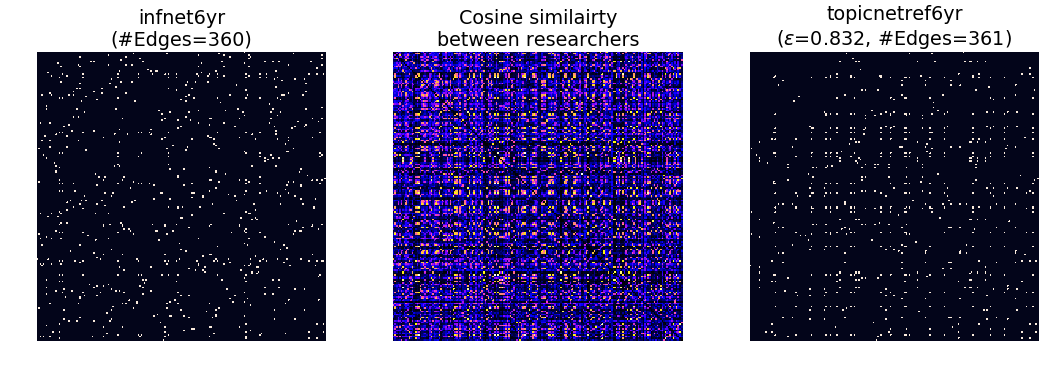

In [63]:
f = plt.figure(figsize=(15, 5))
# ORIGINAL COLALB NET
ax1 = f.add_subplot(131)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
ax1.set_title('infnet6yr\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
ax2 = f.add_subplot(132)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
ax3 = f.add_subplot(133)
ax3.axis('off')
sns.heatmap(topicnet_adj_mat, cbar=False, square=True, ax=ax3)
ax3.set_title('topicnetref6yr\n($\epsilon$={:.3f}, #Edges={})'.format(
    best_threshold,
    int(np.sum(topicnet_adj_mat) // 2)))

f.tight_layout()

In [64]:
f.savefig('./IMG/topicnetref6yr_adjmats.png')

#### As networks:

In [65]:
g_topicnetref6yr = adj_mat_to_graph(topicnet_adj_mat, collabnet.id.tolist())

In [66]:
print(nx.info(g_topicnetref6yr))

Name: 
Type: Graph
Number of nodes: 119
Number of edges: 361
Average degree:   6.0672


2018-03-30 23:36:40,014 : INFO : SAVE_GRAPHS: True


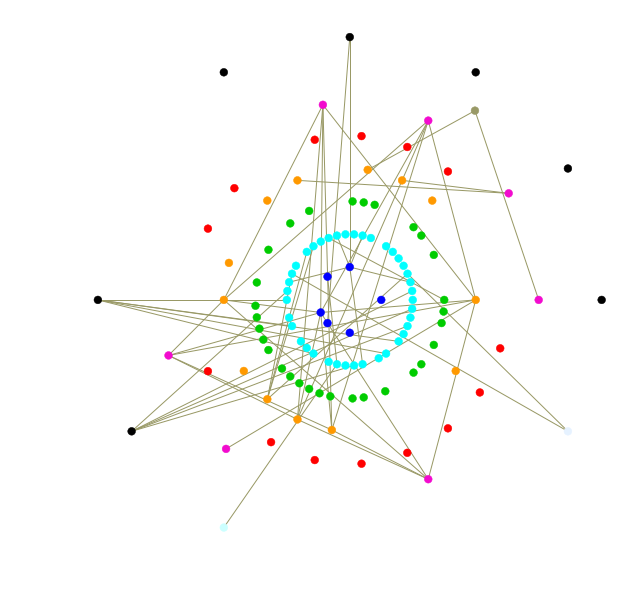

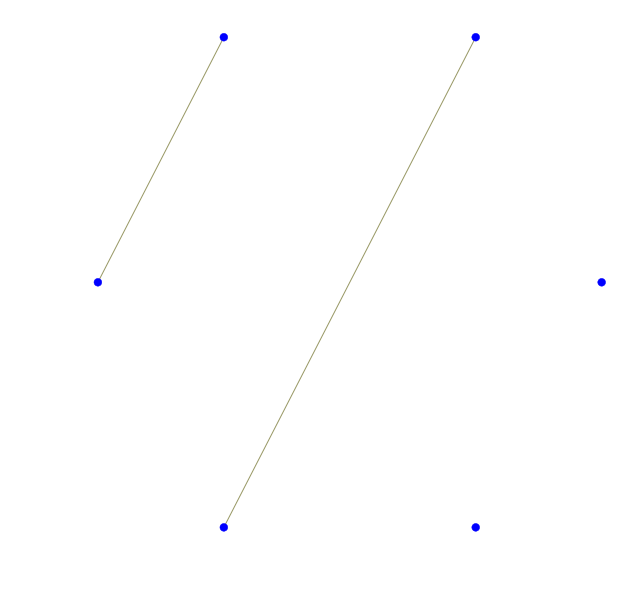

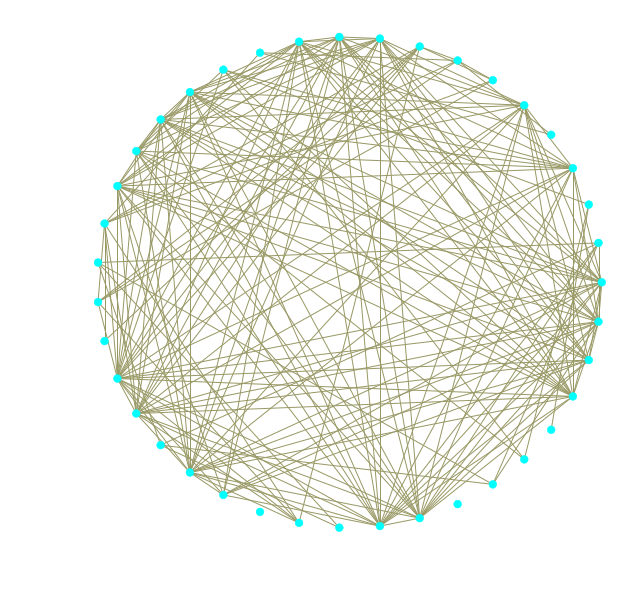

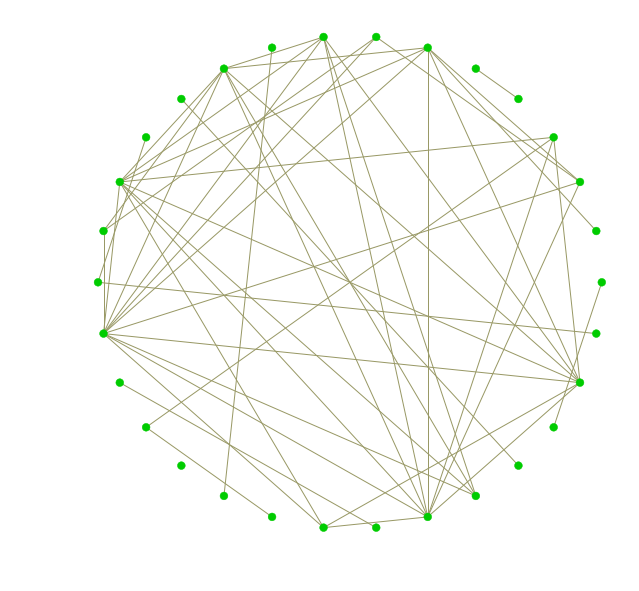

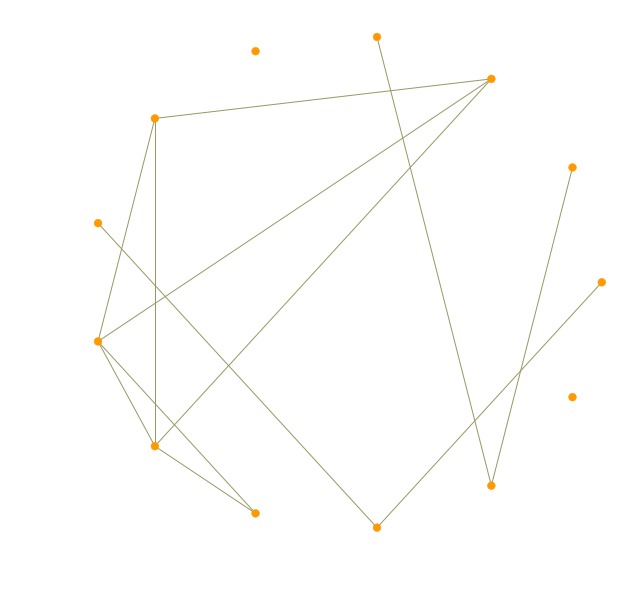

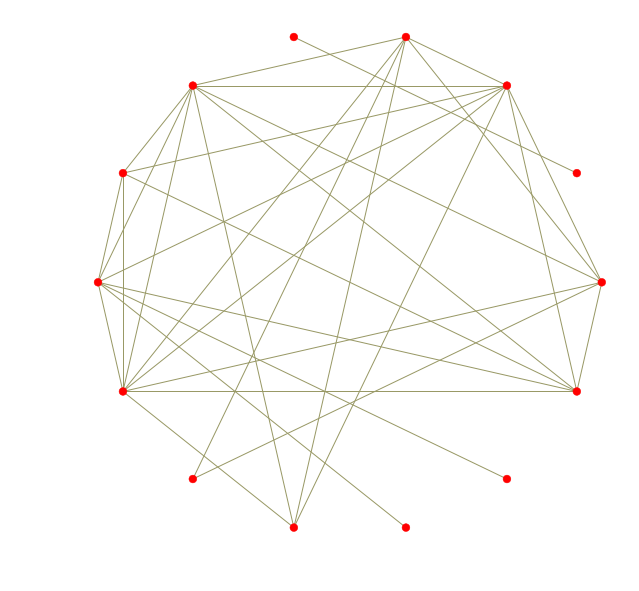

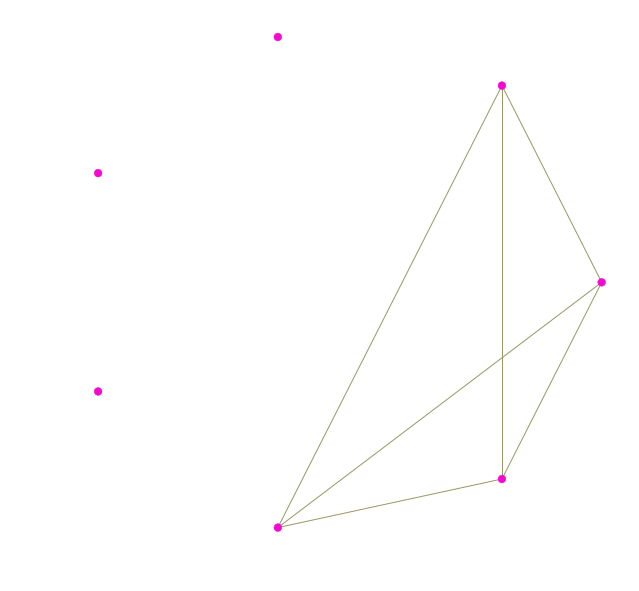

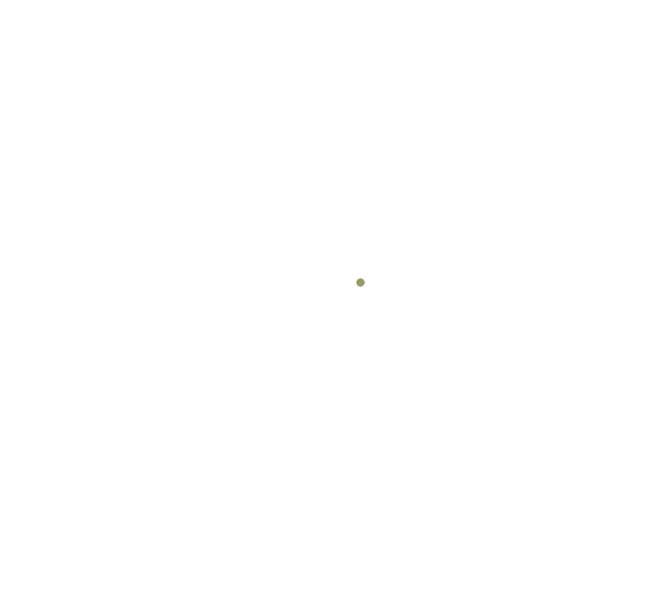

In [67]:
artist.draw_default_layout(
    g_topicnetref6yr,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='topicnetref6yr',
    SAVE_GRAPHS=True)

2018-03-30 23:36:42,735 : INFO : SAVE_GRAPHS: True


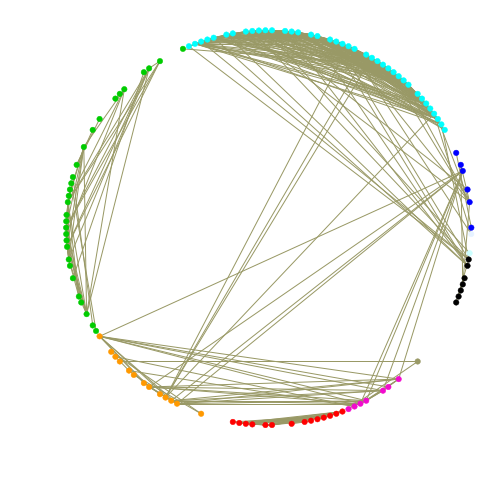

In [68]:
artist.draw_circular_layout(
    g_topicnetref6yr,
    get_lookup_poinf(),
    file_prefix='topicnetref6yr',
    SAVE_GRAPHS=True)

## `topicnetref-6yr-w`

### Deriving `topicnetref-6yr-w`

In [12]:
# load collab net infnet6yrw
collabnet = pd.read_csv(
    '../../data/data_schoolofinf/poinf_collabgraph_2012-2017_weighted.txt',sep='\n',names=['id'])
adj_mat = np.load(
    '../../data/data_schoolofinf/mat/infnet6yrs-weighted-adj-mat.order6yr.pkl')

# # Gather publications for each individuals
# df_pubmapping = get_poinf_pub_mapping()
# topicnet = collabnet.join(df_pubmapping.set_index('id'), how='left',on='id')

In [21]:
# nothing to work on for topicmodel since it is the same topic model...
# Calculate cosine similairty:
cosim = compare_researchers(topicnet.topic_probs.tolist(), tm.num_topics)

In [14]:
# find the best threshold:
thresholds, edges, distances, closest_edges, best_threshold, lowest_avg_distances, best_j_dist_epoch, best_j_dist_threshold = \
find_best_threshold(adj_mat, cosim, num_iter=10000, step_size=0.001,binary_edges=False)

2018-03-31 00:35:54,751 : INFO : Number of ground_truth_edges: 360
2018-03-31 00:35:54,752 : INFO : binary edges: False
2018-03-31 00:35:54,759 : INFO : epoch 0: threshold: 0.001 avg_dist: 0.999 num_edges: 16622
2018-03-31 00:35:54,766 : INFO : epoch 1: threshold: 0.002 avg_dist: 0.999 num_edges: 16609
2018-03-31 00:35:54,773 : INFO : epoch 2: threshold: 0.003 avg_dist: 0.999 num_edges: 16595
2018-03-31 00:35:54,780 : INFO : epoch 3: threshold: 0.004 avg_dist: 0.999 num_edges: 16567
2018-03-31 00:35:54,786 : INFO : epoch 4: threshold: 0.005 avg_dist: 0.999 num_edges: 16532
2018-03-31 00:35:54,793 : INFO : epoch 5: threshold: 0.006 avg_dist: 0.999 num_edges: 16508
2018-03-31 00:35:54,799 : INFO : epoch 6: threshold: 0.007 avg_dist: 0.999 num_edges: 16477
2018-03-31 00:35:54,806 : INFO : epoch 7: threshold: 0.008 avg_dist: 0.999 num_edges: 16434
2018-03-31 00:35:54,812 : INFO : epoch 8: threshold: 0.009 avg_dist: 0.999 num_edges: 16388
2018-03-31 00:35:54,819 : INFO : epoch 9: threshold:

2018-03-31 00:35:55,344 : INFO : epoch 86: threshold: 0.087 avg_dist: 0.998 num_edges: 10700
2018-03-31 00:35:55,351 : INFO : epoch 87: threshold: 0.088 avg_dist: 0.998 num_edges: 10627
2018-03-31 00:35:55,358 : INFO : epoch 88: threshold: 0.089 avg_dist: 0.998 num_edges: 10568
2018-03-31 00:35:55,366 : INFO : epoch 89: threshold: 0.090 avg_dist: 0.998 num_edges: 10504
2018-03-31 00:35:55,372 : INFO : epoch 90: threshold: 0.091 avg_dist: 0.998 num_edges: 10453
2018-03-31 00:35:55,379 : INFO : epoch 91: threshold: 0.092 avg_dist: 0.998 num_edges: 10392
2018-03-31 00:35:55,386 : INFO : epoch 92: threshold: 0.093 avg_dist: 0.998 num_edges: 10329
2018-03-31 00:35:55,393 : INFO : epoch 93: threshold: 0.094 avg_dist: 0.998 num_edges: 10281
2018-03-31 00:35:55,400 : INFO : epoch 94: threshold: 0.095 avg_dist: 0.998 num_edges: 10220
2018-03-31 00:35:55,407 : INFO : epoch 95: threshold: 0.096 avg_dist: 0.998 num_edges: 10169
2018-03-31 00:35:55,414 : INFO : epoch 96: threshold: 0.097 avg_dist: 

2018-03-31 00:35:55,964 : INFO : epoch 174: threshold: 0.175 avg_dist: 0.997 num_edges: 6737
2018-03-31 00:35:55,971 : INFO : epoch 175: threshold: 0.176 avg_dist: 0.997 num_edges: 6701
2018-03-31 00:35:55,978 : INFO : epoch 176: threshold: 0.177 avg_dist: 0.997 num_edges: 6676
2018-03-31 00:35:55,985 : INFO : epoch 177: threshold: 0.178 avg_dist: 0.997 num_edges: 6644
2018-03-31 00:35:55,991 : INFO : epoch 178: threshold: 0.179 avg_dist: 0.997 num_edges: 6600
2018-03-31 00:35:55,999 : INFO : epoch 179: threshold: 0.180 avg_dist: 0.997 num_edges: 6571
2018-03-31 00:35:56,005 : INFO : epoch 180: threshold: 0.181 avg_dist: 0.997 num_edges: 6540
2018-03-31 00:35:56,013 : INFO : epoch 181: threshold: 0.182 avg_dist: 0.997 num_edges: 6503
2018-03-31 00:35:56,020 : INFO : epoch 182: threshold: 0.183 avg_dist: 0.997 num_edges: 6469
2018-03-31 00:35:56,026 : INFO : epoch 183: threshold: 0.184 avg_dist: 0.997 num_edges: 6432
2018-03-31 00:35:56,033 : INFO : epoch 184: threshold: 0.185 avg_dist:

2018-03-31 00:35:56,582 : INFO : epoch 263: threshold: 0.264 avg_dist: 0.994 num_edges: 4486
2018-03-31 00:35:56,589 : INFO : epoch 264: threshold: 0.265 avg_dist: 0.994 num_edges: 4467
2018-03-31 00:35:56,595 : INFO : epoch 265: threshold: 0.266 avg_dist: 0.994 num_edges: 4442
2018-03-31 00:35:56,603 : INFO : epoch 266: threshold: 0.267 avg_dist: 0.994 num_edges: 4424
2018-03-31 00:35:56,610 : INFO : epoch 267: threshold: 0.268 avg_dist: 0.994 num_edges: 4404
2018-03-31 00:35:56,618 : INFO : epoch 268: threshold: 0.269 avg_dist: 0.994 num_edges: 4386
2018-03-31 00:35:56,624 : INFO : epoch 269: threshold: 0.270 avg_dist: 0.994 num_edges: 4363
2018-03-31 00:35:56,631 : INFO : epoch 270: threshold: 0.271 avg_dist: 0.994 num_edges: 4339
2018-03-31 00:35:56,638 : INFO : epoch 271: threshold: 0.272 avg_dist: 0.994 num_edges: 4326
2018-03-31 00:35:56,646 : INFO : epoch 272: threshold: 0.273 avg_dist: 0.994 num_edges: 4307
2018-03-31 00:35:56,652 : INFO : epoch 273: threshold: 0.274 avg_dist:

2018-03-31 00:35:57,196 : INFO : epoch 352: threshold: 0.353 avg_dist: 0.989 num_edges: 3164
2018-03-31 00:35:57,203 : INFO : epoch 353: threshold: 0.354 avg_dist: 0.989 num_edges: 3150
2018-03-31 00:35:57,211 : INFO : epoch 354: threshold: 0.355 avg_dist: 0.989 num_edges: 3143
2018-03-31 00:35:57,217 : INFO : epoch 355: threshold: 0.356 avg_dist: 0.989 num_edges: 3132
2018-03-31 00:35:57,225 : INFO : epoch 356: threshold: 0.357 avg_dist: 0.989 num_edges: 3122
2018-03-31 00:35:57,232 : INFO : epoch 357: threshold: 0.358 avg_dist: 0.989 num_edges: 3107
2018-03-31 00:35:57,240 : INFO : epoch 358: threshold: 0.359 avg_dist: 0.989 num_edges: 3098
2018-03-31 00:35:57,247 : INFO : epoch 359: threshold: 0.360 avg_dist: 0.989 num_edges: 3084
2018-03-31 00:35:57,253 : INFO : epoch 360: threshold: 0.361 avg_dist: 0.989 num_edges: 3067
2018-03-31 00:35:57,260 : INFO : epoch 361: threshold: 0.362 avg_dist: 0.989 num_edges: 3055
2018-03-31 00:35:57,267 : INFO : epoch 362: threshold: 0.363 avg_dist:

2018-03-31 00:35:57,851 : INFO : epoch 440: threshold: 0.441 avg_dist: 0.984 num_edges: 2236
2018-03-31 00:35:57,858 : INFO : epoch 441: threshold: 0.442 avg_dist: 0.984 num_edges: 2227
2018-03-31 00:35:57,864 : INFO : epoch 442: threshold: 0.443 avg_dist: 0.984 num_edges: 2222
2018-03-31 00:35:57,871 : INFO : epoch 443: threshold: 0.444 avg_dist: 0.983 num_edges: 2208
2018-03-31 00:35:57,877 : INFO : epoch 444: threshold: 0.445 avg_dist: 0.983 num_edges: 2200
2018-03-31 00:35:57,884 : INFO : epoch 445: threshold: 0.446 avg_dist: 0.983 num_edges: 2192
2018-03-31 00:35:57,891 : INFO : epoch 446: threshold: 0.447 avg_dist: 0.983 num_edges: 2189
2018-03-31 00:35:57,898 : INFO : epoch 447: threshold: 0.448 avg_dist: 0.983 num_edges: 2181
2018-03-31 00:35:57,904 : INFO : epoch 448: threshold: 0.449 avg_dist: 0.983 num_edges: 2176
2018-03-31 00:35:57,911 : INFO : epoch 449: threshold: 0.450 avg_dist: 0.983 num_edges: 2169
2018-03-31 00:35:57,918 : INFO : epoch 450: threshold: 0.451 avg_dist:

2018-03-31 00:35:58,445 : INFO : epoch 528: threshold: 0.529 avg_dist: 0.976 num_edges: 1613
2018-03-31 00:35:58,453 : INFO : epoch 529: threshold: 0.530 avg_dist: 0.976 num_edges: 1606
2018-03-31 00:35:58,459 : INFO : epoch 530: threshold: 0.531 avg_dist: 0.976 num_edges: 1601
2018-03-31 00:35:58,466 : INFO : epoch 531: threshold: 0.532 avg_dist: 0.976 num_edges: 1591
2018-03-31 00:35:58,472 : INFO : epoch 532: threshold: 0.533 avg_dist: 0.976 num_edges: 1589
2018-03-31 00:35:58,479 : INFO : epoch 533: threshold: 0.534 avg_dist: 0.976 num_edges: 1584
2018-03-31 00:35:58,485 : INFO : epoch 534: threshold: 0.535 avg_dist: 0.976 num_edges: 1581
2018-03-31 00:35:58,493 : INFO : epoch 535: threshold: 0.536 avg_dist: 0.975 num_edges: 1577
2018-03-31 00:35:58,500 : INFO : epoch 536: threshold: 0.537 avg_dist: 0.975 num_edges: 1565
2018-03-31 00:35:58,506 : INFO : epoch 537: threshold: 0.538 avg_dist: 0.975 num_edges: 1555
2018-03-31 00:35:58,513 : INFO : epoch 538: threshold: 0.539 avg_dist:

2018-03-31 00:35:59,117 : INFO : epoch 616: threshold: 0.617 avg_dist: 0.971 num_edges: 1177
2018-03-31 00:35:59,123 : INFO : epoch 617: threshold: 0.618 avg_dist: 0.971 num_edges: 1170
2018-03-31 00:35:59,130 : INFO : epoch 618: threshold: 0.619 avg_dist: 0.971 num_edges: 1167
2018-03-31 00:35:59,136 : INFO : epoch 619: threshold: 0.620 avg_dist: 0.971 num_edges: 1164
2018-03-31 00:35:59,143 : INFO : epoch 620: threshold: 0.621 avg_dist: 0.971 num_edges: 1160
2018-03-31 00:35:59,149 : INFO : epoch 621: threshold: 0.622 avg_dist: 0.971 num_edges: 1155
2018-03-31 00:35:59,156 : INFO : epoch 622: threshold: 0.623 avg_dist: 0.971 num_edges: 1152
2018-03-31 00:35:59,163 : INFO : epoch 623: threshold: 0.624 avg_dist: 0.971 num_edges: 1145
2018-03-31 00:35:59,170 : INFO : epoch 624: threshold: 0.625 avg_dist: 0.971 num_edges: 1142
2018-03-31 00:35:59,176 : INFO : epoch 625: threshold: 0.626 avg_dist: 0.971 num_edges: 1135
2018-03-31 00:35:59,183 : INFO : epoch 626: threshold: 0.627 avg_dist:

2018-03-31 00:35:59,713 : INFO : epoch 704: threshold: 0.705 avg_dist: 0.966 num_edges: 816
2018-03-31 00:35:59,720 : INFO : epoch 705: threshold: 0.706 avg_dist: 0.966 num_edges: 813
2018-03-31 00:35:59,727 : INFO : epoch 706: threshold: 0.707 avg_dist: 0.966 num_edges: 812
2018-03-31 00:35:59,734 : INFO : epoch 707: threshold: 0.708 avg_dist: 0.966 num_edges: 808
2018-03-31 00:35:59,741 : INFO : epoch 708: threshold: 0.709 avg_dist: 0.966 num_edges: 804
2018-03-31 00:35:59,748 : INFO : epoch 709: threshold: 0.710 avg_dist: 0.966 num_edges: 800
2018-03-31 00:35:59,755 : INFO : epoch 710: threshold: 0.711 avg_dist: 0.966 num_edges: 796
2018-03-31 00:35:59,761 : INFO : epoch 711: threshold: 0.712 avg_dist: 0.966 num_edges: 791
2018-03-31 00:35:59,768 : INFO : epoch 712: threshold: 0.713 avg_dist: 0.966 num_edges: 787
2018-03-31 00:35:59,774 : INFO : epoch 713: threshold: 0.714 avg_dist: 0.966 num_edges: 786
2018-03-31 00:35:59,781 : INFO : epoch 714: threshold: 0.715 avg_dist: 0.965 num

2018-03-31 00:36:00,369 : INFO : epoch 793: threshold: 0.794 avg_dist: 0.968 num_edges: 474
2018-03-31 00:36:00,375 : INFO : epoch 794: threshold: 0.795 avg_dist: 0.968 num_edges: 469
2018-03-31 00:36:00,382 : INFO : epoch 795: threshold: 0.796 avg_dist: 0.968 num_edges: 466
2018-03-31 00:36:00,388 : INFO : epoch 796: threshold: 0.797 avg_dist: 0.968 num_edges: 461
2018-03-31 00:36:00,396 : INFO : epoch 797: threshold: 0.798 avg_dist: 0.968 num_edges: 454
2018-03-31 00:36:00,402 : INFO : epoch 798: threshold: 0.799 avg_dist: 0.968 num_edges: 451
2018-03-31 00:36:00,409 : INFO : epoch 799: threshold: 0.800 avg_dist: 0.968 num_edges: 448
2018-03-31 00:36:00,416 : INFO : epoch 800: threshold: 0.801 avg_dist: 0.968 num_edges: 446
2018-03-31 00:36:00,422 : INFO : epoch 801: threshold: 0.802 avg_dist: 0.968 num_edges: 444
2018-03-31 00:36:00,429 : INFO : epoch 802: threshold: 0.803 avg_dist: 0.968 num_edges: 443
2018-03-31 00:36:00,436 : INFO : epoch 803: threshold: 0.804 avg_dist: 0.968 num

2018-03-31 00:36:00,960 : INFO : epoch 882: threshold: 0.883 avg_dist: 0.989 num_edges: 211
2018-03-31 00:36:00,968 : INFO : epoch 883: threshold: 0.884 avg_dist: 0.989 num_edges: 211
2018-03-31 00:36:00,974 : INFO : epoch 884: threshold: 0.885 avg_dist: 0.989 num_edges: 208
2018-03-31 00:36:00,981 : INFO : epoch 885: threshold: 0.886 avg_dist: 0.993 num_edges: 207
2018-03-31 00:36:00,987 : INFO : epoch 886: threshold: 0.887 avg_dist: 0.993 num_edges: 207
2018-03-31 00:36:00,994 : INFO : epoch 887: threshold: 0.888 avg_dist: 0.993 num_edges: 206
2018-03-31 00:36:01,000 : INFO : epoch 888: threshold: 0.889 avg_dist: 0.992 num_edges: 203
2018-03-31 00:36:01,007 : INFO : epoch 889: threshold: 0.890 avg_dist: 0.992 num_edges: 201
2018-03-31 00:36:01,013 : INFO : epoch 890: threshold: 0.891 avg_dist: 0.992 num_edges: 200
2018-03-31 00:36:01,019 : INFO : epoch 891: threshold: 0.892 avg_dist: 0.992 num_edges: 196
2018-03-31 00:36:01,026 : INFO : epoch 892: threshold: 0.893 avg_dist: 0.992 num

2018-03-31 00:36:01,551 : INFO : epoch 971: threshold: 0.972 avg_dist: 1.000 num_edges: 29
2018-03-31 00:36:01,557 : INFO : epoch 972: threshold: 0.973 avg_dist: 1.000 num_edges: 28
2018-03-31 00:36:01,564 : INFO : epoch 973: threshold: 0.974 avg_dist: 1.000 num_edges: 28
2018-03-31 00:36:01,627 : INFO : epoch 974: threshold: 0.975 avg_dist: 1.000 num_edges: 26
2018-03-31 00:36:01,633 : INFO : epoch 975: threshold: 0.976 avg_dist: 1.000 num_edges: 24
2018-03-31 00:36:01,640 : INFO : epoch 976: threshold: 0.977 avg_dist: 1.000 num_edges: 21
2018-03-31 00:36:01,646 : INFO : epoch 977: threshold: 0.978 avg_dist: 1.000 num_edges: 20
2018-03-31 00:36:01,653 : INFO : epoch 978: threshold: 0.979 avg_dist: 1.000 num_edges: 19
2018-03-31 00:36:01,659 : INFO : epoch 979: threshold: 0.980 avg_dist: 1.000 num_edges: 17
2018-03-31 00:36:01,666 : INFO : epoch 980: threshold: 0.981 avg_dist: 1.000 num_edges: 17
2018-03-31 00:36:01,673 : INFO : epoch 981: threshold: 0.982 avg_dist: 1.000 num_edges: 16

threshold: 0.832 dist 0.965210 (721, 0.722) edges 361/360 (831)


threshold: 0.832 dist 0.965210 (721, 0.722) edges 361/360 (831)

In [15]:
# Set the edges:
topicnet_adj_mat = set_edges(cosim, best_threshold, binary=False) # the edges are the cosine similarities!
topicnet_adj_mat.dump('./res/topicnetref6yr_adjmat.pkl')

2018-03-31 00:36:01,788 : INFO : dimension: 183, 183


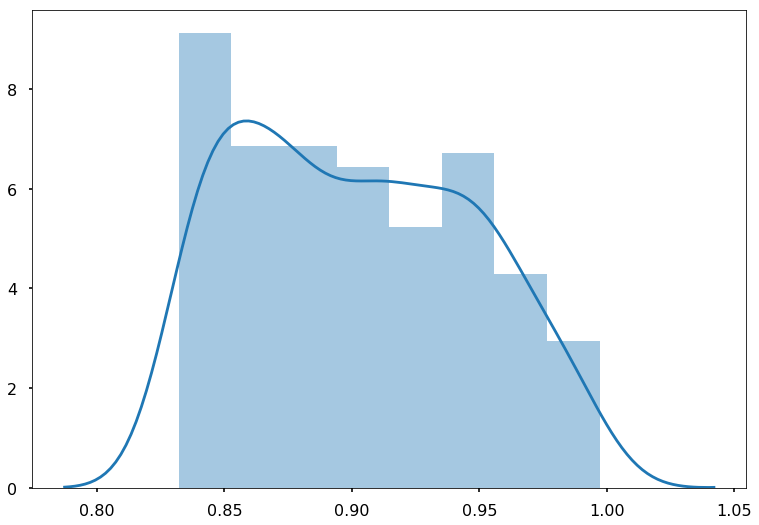

In [26]:
dist = np.triu(topicnet_adj_mat)
dist = np.ravel(dist[dist>0])
sns.distplot(dist,hist=True)

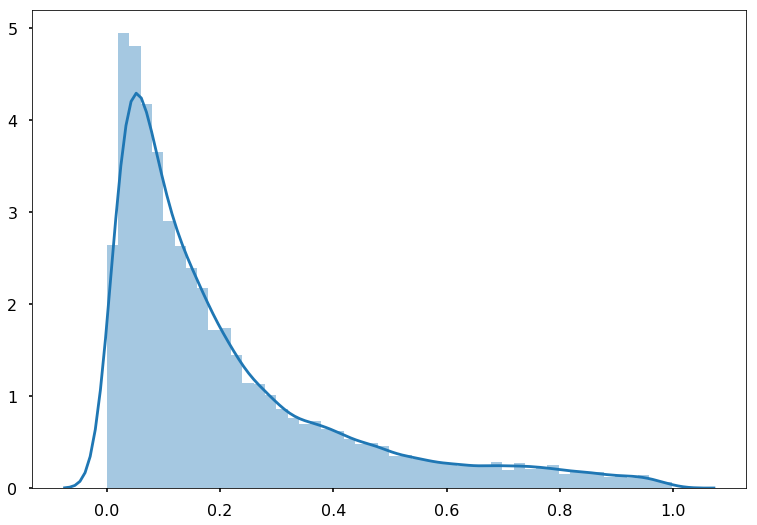

In [27]:
dist = np.triu(cosim)
dist = np.ravel(dist[dist>0])
sns.distplot(dist,hist=True)

### Visualise

#### Thresholding:

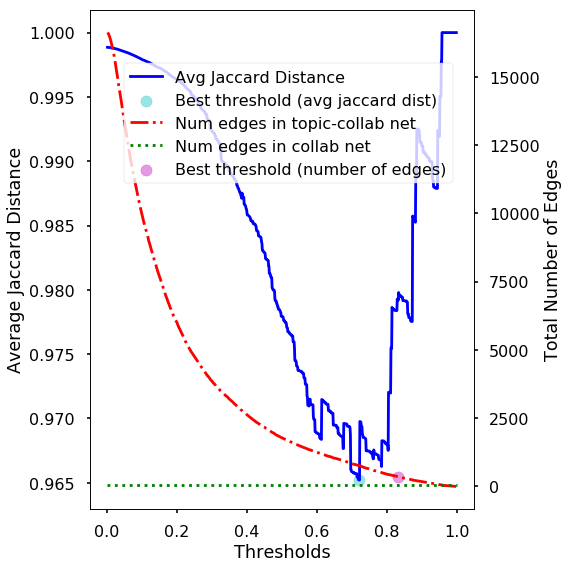

In [14]:
f = threshold_plot(
    thresholds,
    distances,
    edges,
    best_threshold,
    closest_edges,
    best_j_dist_threshold,
    lowest_avg_distances,
    adj_mat
)

In [62]:
f.savefig(
    './IMG/topicnetref6yrw_thresholding.png', format='png', bbox_inches='tight')

####  As series of matrices:

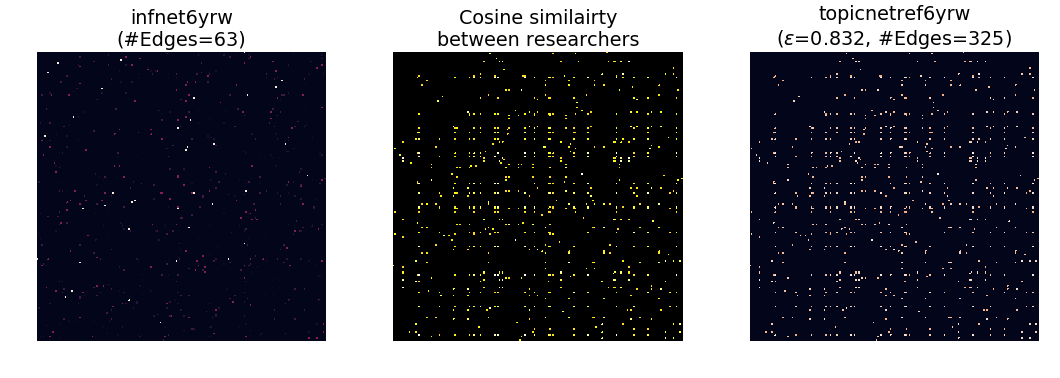

In [16]:
f = plt.figure(figsize=(15, 5))
# ORIGINAL COLALB NET
ax1 = f.add_subplot(131)
ax1.axis('off')
sns.heatmap(adj_mat, cbar=False, square=True)
ax1.set_title('infnet6yrw\n(#Edges={})'.format(int(np.sum(adj_mat) // 2)))

# COSIM
ax2 = f.add_subplot(132)
ax2.axis('off')
sns.heatmap(
    cosim,
    cbar=False,
    square=True,
    ax=ax2,
    vmax=1,
    vmin=0,
    robust=True,
    cmap='gnuplot2')
ax2.set_title('Cosine similairty\nbetween researchers')

# FINAL :
ax3 = f.add_subplot(133)
ax3.axis('off')
sns.heatmap(topicnet_adj_mat, cbar=False, square=True, ax=ax3)
ax3.set_title('topicnetref6yrw\n($\epsilon$={:.3f}, #Edges={})'.format(
    best_threshold,
    int(np.sum(topicnet_adj_mat) // 2)))

f.tight_layout()

In [28]:
f.savefig('./IMG/topicnetref6yr_adjmats.png')

#### As networks:

In [29]:
g_topicnetref6yrw = adj_mat_to_graph(topicnet_adj_mat, collabnet.id.tolist())

In [30]:
print(nx.info(g_topicnetref6yrw))

Name: 
Type: Graph
Number of nodes: 119
Number of edges: 361
Average degree:   6.0672


2018-03-31 00:43:07,885 : INFO : SAVE_GRAPHS: True


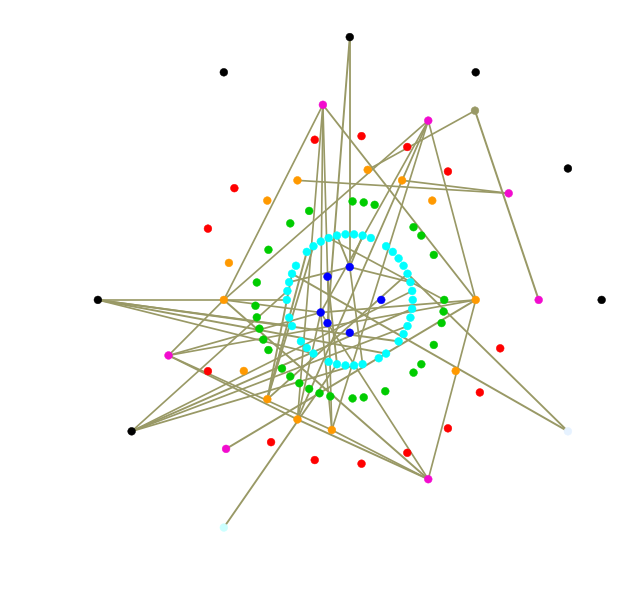

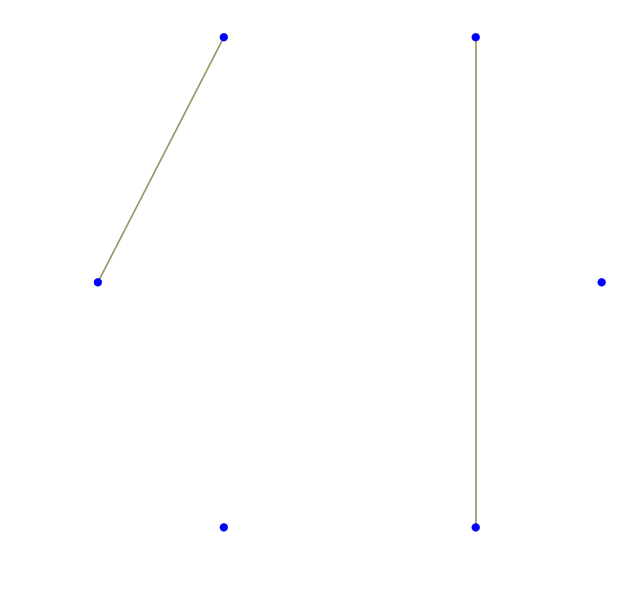

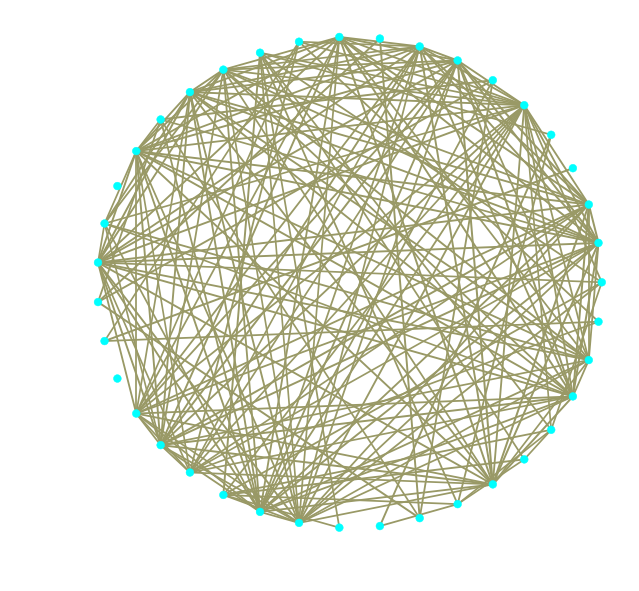

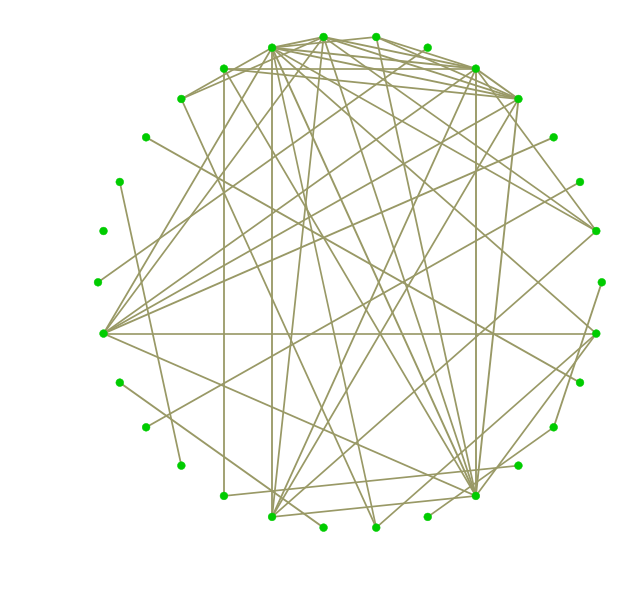

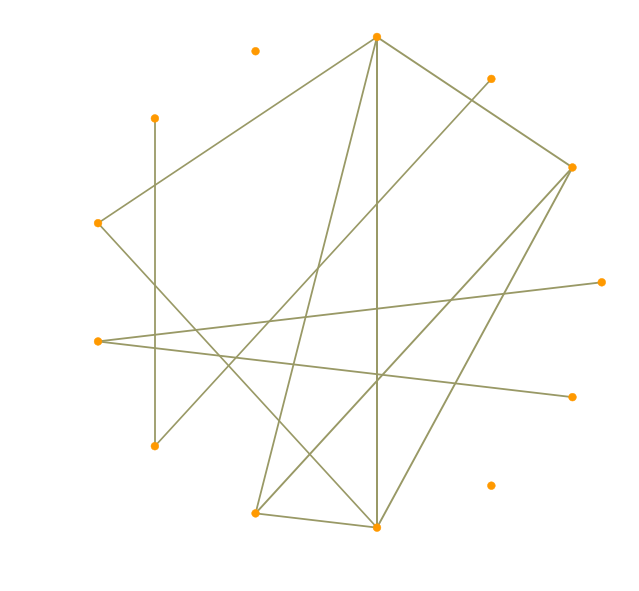

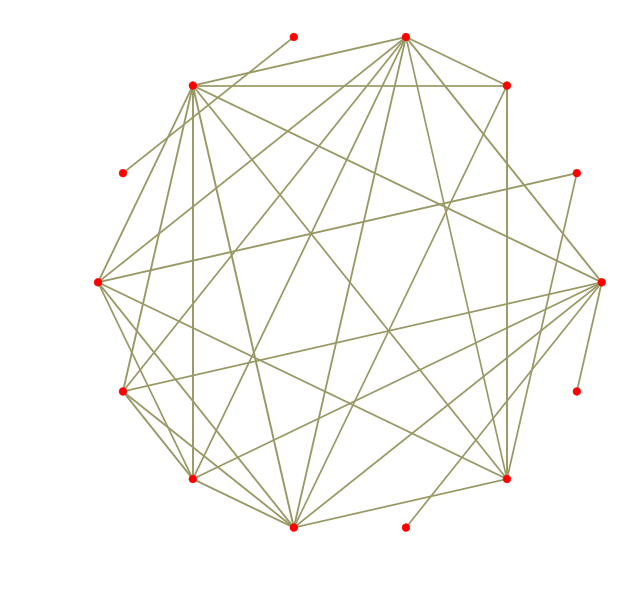

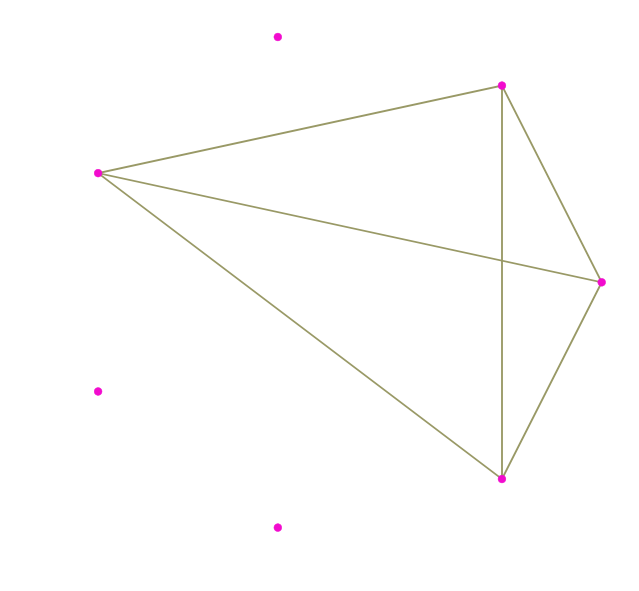

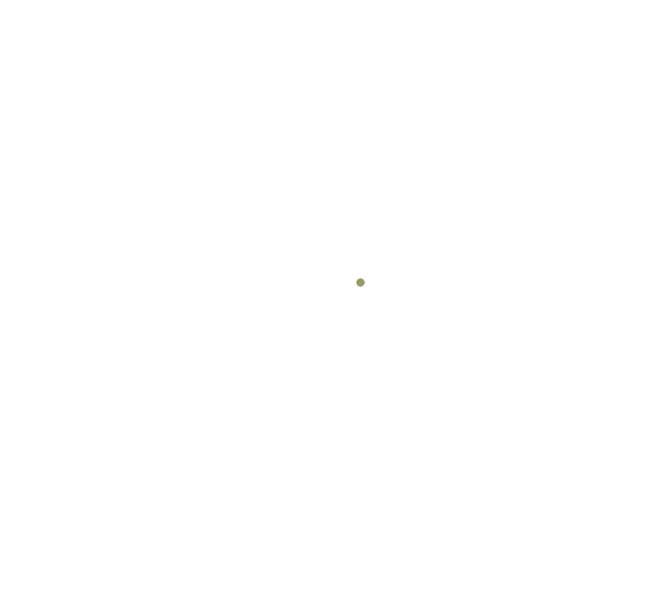

In [36]:
artist.draw_default_layout(
    g_topicnetref6yrw,
    lookup_poinf=get_lookup_poinf(),
    file_prefix='topicnetref6yrw',
    with_weight=True,scale=2,
    SAVE_GRAPHS=True)

2018-03-31 00:43:43,878 : INFO : SAVE_GRAPHS: True


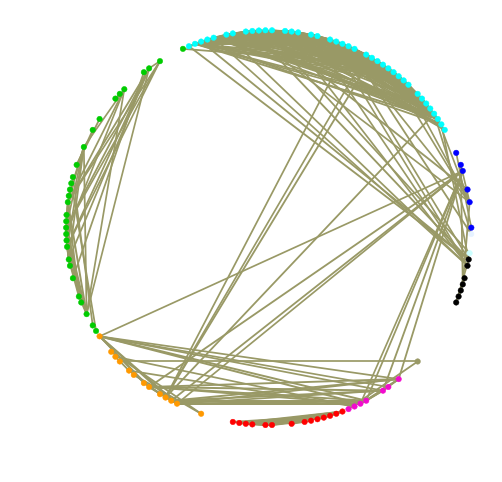

In [37]:
artist.draw_circular_layout(
    g_topicnetref6yrw,
    get_lookup_poinf(),
    file_prefix='topicnetref6yrw',
    with_weight=True,
    SAVE_GRAPHS=True)